# 0.0 Imports

In [140]:
import pandas             as pd
import numpy              as np
import pandas.io.sql      as sqlio
import xgboost            as xgb
import scikitplot         as skplt

import matplotlib.pyplot  as plt
import seaborn            as sns

from IPython.display      import Image
from scipy                import stats            as ss
from sklearn              import preprocessing    as pp
from sklearn              import model_selection  as ms
from sklearn              import ensemble         as en
from sklearn              import metrics          as m
from scikitplot           import metrics          as mt

from sklearn.ensemble     import RandomForestClassifier
from boruta               import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB
from skopt                import forest_minimize
from skopt.plots          import plot_convergence

import psycopg2
import warnings
import kaggle
warnings.filterwarnings("ignore")

%matplotlib inline

## 0.1 Helper Functions

In [4]:
def create_connection_database(host_name, port_num, database_name, user_name, password_name):
    connection = None
    connection = psycopg2.connect(
                        host = host_name,
                        port = port_num,
                        database = database_name,
                        user = user_name,
                        password = password_name)
    return connection

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v   

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def precision_at_k(df,yhat_proba,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df['response'].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

def recall_at_k(df,yhat_proba,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['recall_at_k']=df['response'].cumsum()/df['response'].sum()
    return df.loc[k,'recall_at_k']

def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        precision = round(precision_at_k(x_val_fold, yhat_model, 0.20),3)
        recall= round(recall_at_k(x_val_fold, yhat_model, 0.20),3)
        f1 = round(2*(precision*recall)/(precision+recall),3)
        roc = round(m.roc_auc_score(y_val_fold,yhat_model[:,1]),3)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_list.append(roc)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)            
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance


## 0.2 Loading Data

In [5]:
#connect to the DB
host_name     = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
port_num      = 5432 
database_name = "comunidadedsdb"
user_name     = "member"
password_name = "cdspa"

#make connection with DB
conn = create_connection_database (host_name, port_num, database_name, user_name, password_name)

#checking tables in schema
cur = conn.cursor()

cur.execute("""SELECT table_schema, table_name
                      FROM information_schema.tables
                      WHERE table_schema != 'pg_catalog'
                      AND table_schema != 'information_schema'
                      AND table_type='BASE TABLE'
                      ORDER BY table_schema, table_name""")

schemas_db = cur.fetchall()

# cursor close
cur.close()

df_insurance = sqlio.read_sql_query("Select * from pa004.insurance", conn)
df_vehicle = sqlio.read_sql_query("Select * from pa004.vehicle", conn)
df_users = sqlio.read_sql_query("Select * from pa004.users", conn)

#close the connection
conn.close()

#checking each shape of dataframes
print('Tables shape:\n Insurance: {}\n Vehicle: {}\n Users: {}'.format(df_insurance.shape,df_vehicle.shape, df_users.shape ))

Tables shape:
 Insurance: (381109, 5)
 Vehicle: (381109, 4)
 Users: (381109, 5)


In [6]:
df0 = df_users.merge(df_vehicle, how = 'outer', on='id')
df0 = df0.merge(df_insurance, how = 'outer', on='id')

#cleaning memory of dataframes used to collect data from DB
df_vehicle = None
df_users = None
df_insurance = None

df0.sample(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
304596,304597,Male,40,4.0,26.0,1,1-2 Year,Yes,0,30006.0,65,1
26148,26149,Male,48,41.0,124.0,1,> 2 Years,Yes,0,33466.0,254,0
242224,242225,Female,22,2.0,152.0,1,< 1 Year,No,0,2630.0,297,0
107981,107982,Male,37,8.0,124.0,1,1-2 Year,Yes,0,34427.0,289,1
232359,232360,Male,46,48.0,14.0,1,1-2 Year,Yes,0,2630.0,233,0


### 0.2.1 Loading test data

In [190]:
!kaggle datasets list -s anmolkumar/health-insurance-cross-sell-prediction
!kaggle datasets files -v anmolkumar/health-insurance-cross-sell-prediction
!kaggle datasets download anmolkumar/health-insurance-cross-sell-prediction -f test.csv -p ./dataset/ --unzip
df_test = pd.read_csv('./dataset/test.csv')

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
b'anmolkumar/health-insurance-cross-sell-prediction               Health Insurance Cross Sell Prediction \xf0\x9f\x8f\xa0 \xf0\x9f\x8f\xa5          6MB  2020-09-11 18:39:31          12408        435  1.0              '
polarbearyap/health-insurance-cross-sell-prediction-submission  Health Insurance Cross Sell Prediction Submission   2MB  2020-11-08 13:44:36              3          0  0.5294118        
name,size,creationDate

train.csv,20MB,2020-09-11 18:39:31

sample_submission.csv,1MB,2020-09-11 18:39:31

test.csv,7MB,2020-09-11 18:39:31

test.csv.zip: Skipping, found more recently modified local copy (use --force to fo

In [191]:
df_test.columns = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage']

# 1.0 Data Description

In [7]:
df1 = df0.copy()

## 1.1 Rename Columns

In [8]:
cols = df1.columns
cols

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

- Columns names already in snake case

## 1.2 Data Dimension

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.3 Data Types

In [10]:
df1['region_code'] = df1['region_code'].astype(np.int64)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

- Types are OK:
    - Only numbers (int and float) and categories (object). There is no dates to convert.

## 1.4 Check NAN

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

- There is no NAN in original datas

## 1.5 Fillout NA

Not necessary, as seen in 1.4 section

## 1.6 Columns Description

In [12]:
cols = df1.columns
cols

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')


- **Id**: Customer identifier 
- **Gender**: Gender of customer
- **Age**: Age of customer
- **Driving License**: 0 if customer does not have the permission for drive; 1 if customer has the permission for drive
- **Region Code**: Region code of customer
- **Previously Insured**: 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.
- **Vehicle Age**: Age of vehicle
- **Vehicle Damage**: 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage
- **Annual Premium**: amount paid for health insurance to the company anualy.
- **Policy sales channel**: anonymous code for contact with customer.
- **Vintage**: time (in days) that customer bought his health assurance.
- **Response**: 0 if customer has no interest in product; 1 if customer has interest in product

## 1.7 Descriptive Statistical

In [192]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]

cat_attributes = df1[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender', 'region_code', 'policy_sales_channel' ]]

target_atribute = df1['response']

### 1.7.1 Numerical Attributes

In [193]:
# Central Tendency - Mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max()- x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate

m1 = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


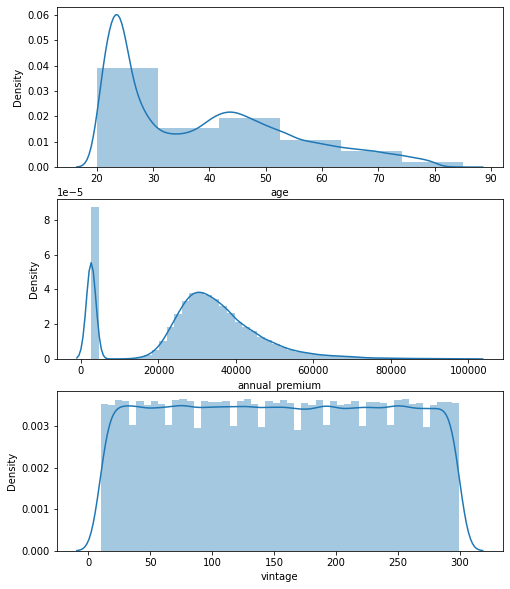

In [15]:
fig, axs = plt.subplots(3, figsize = (8,10))
sns.distplot(df1['age'], ax=axs[0], bins = 6)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

In [16]:
bins = pd.cut(df1['age'], [19, 30, 40, 50, 60, 70, 80, 90])

df1.groupby(bins)['age'].size().sum()
print('Age analysis:')
print('Percent of 20-29: {}'.format(round((df1.groupby(bins)['age'].size()[0]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 30-39: {}'.format(round((df1.groupby(bins)['age'].size()[1]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 40-49: {}'.format(round((df1.groupby(bins)['age'].size()[2]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 50-59: {}'.format(round((df1.groupby(bins)['age'].size()[3]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 60-69: {}'.format(round((df1.groupby(bins)['age'].size()[4]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 70-79: {}'.format(round((df1.groupby(bins)['age'].size()[5]/df1.groupby(bins)['age'].size().sum()),3)))
print('Percent of 80-85: {}'.format(round((df1.groupby(bins)['age'].size()[6]/df1.groupby(bins)['age'].size().sum()),4)))

Age analysis:
Percent of 20-29: 0.424
Percent of 30-39: 0.145
Percent of 40-49: 0.199
Percent of 50-59: 0.119
Percent of 60-69: 0.073
Percent of 70-79: 0.04
Percent of 80-85: 0.0003


**Data Description Summary for numerical attributes:**

1. **Age** 
    - Range is from 20 to 85. 
    - Mean is 38.82 and median is 36. 
    - Higher density is from 20 to 29 with 42%, followed by 40 to 49 with 19,9%.
****    
2. **Annual_premium**
    - Range is from 2630 to 540165.
    - There is a peak in 2630, and a high density around 20000 to 60000.
****      
3. **Vintage**
    - Range is from 10 to 299.
    - Mean and median are 154. 

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

driving_license           2
previously_insured        2
vehicle_damage            2
vehicle_age               3
gender                    2
region_code              53
policy_sales_channel    155
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

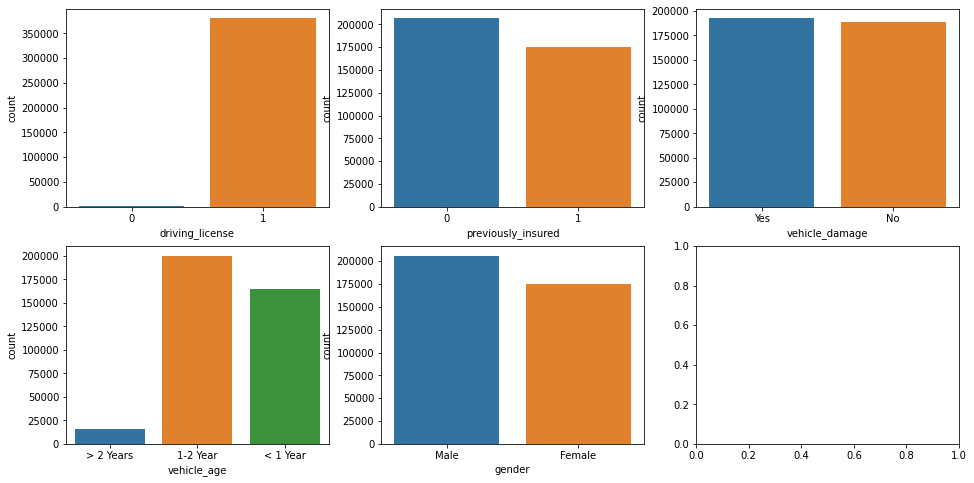

In [18]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16,8))

sns.countplot(x ='driving_license', data= df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data=df1, ax=axs[0][1])
sns.countplot(x = 'vehicle_damage', data=df1, ax=axs[0][2])

sns.countplot(x = 'vehicle_age', data=df1,ax=axs[1][0])
sns.countplot(x = 'gender', data=df1,ax=axs[1][1])

<AxesSubplot:xlabel='region_code', ylabel='count'>

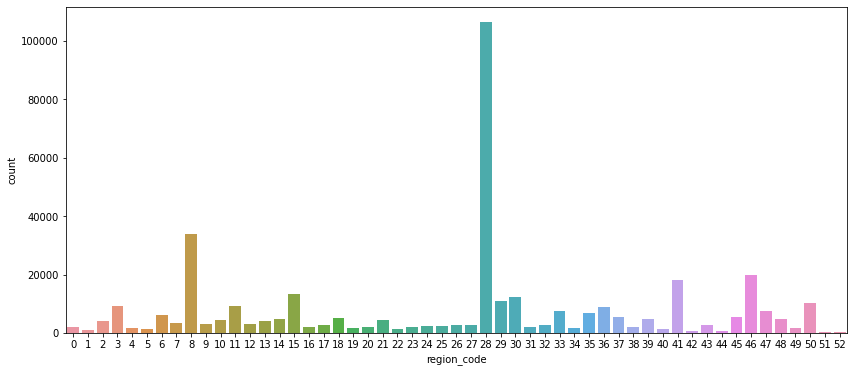

In [19]:
fig= plt.subplots(figsize = (14,6))
sns.countplot(x = 'region_code', data=df1)

<AxesSubplot:xlabel='policy_sales_channel', ylabel='index'>

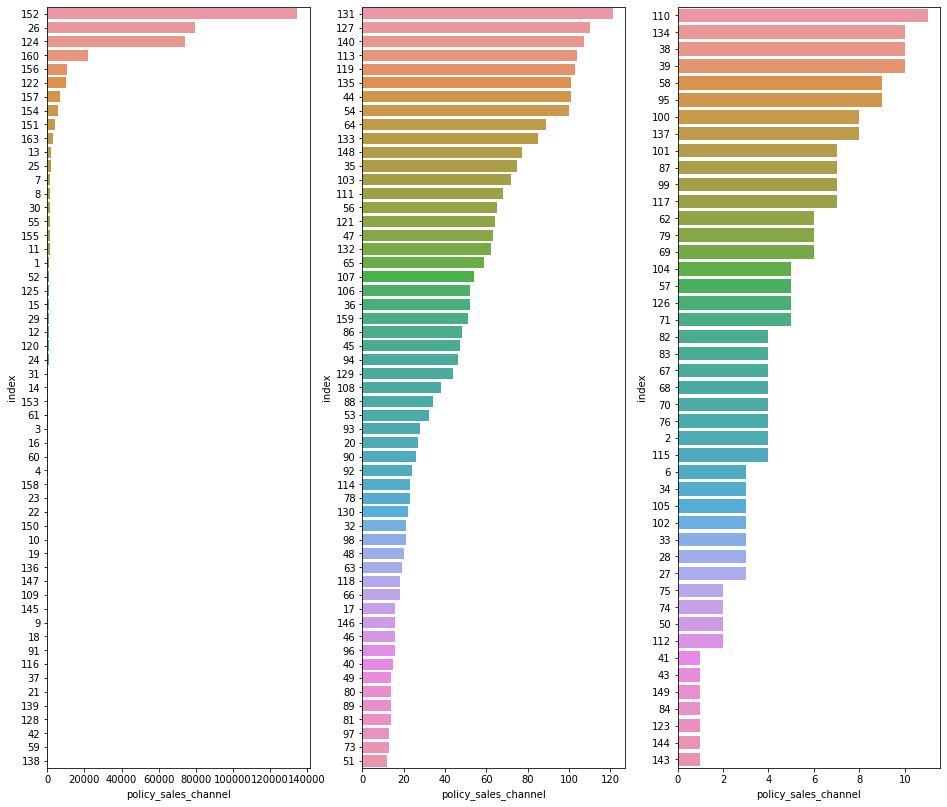

In [20]:
df_policy_1 = df1['policy_sales_channel'].value_counts().iloc[0:55]
df_policy_1 = df_policy_1.reset_index()
df_policy_2 = df1['policy_sales_channel'].value_counts().iloc[55:110]
df_policy_2 = df_policy_2.reset_index()
df_policy_3 = df1['policy_sales_channel'].value_counts().iloc[110:156]
df_policy_3 = df_policy_3.reset_index()

fig, axs = plt.subplots(ncols= 3, figsize = (16,14))
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_1, ax=axs[0],orient = 'h',order = df_policy_1['index'])
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_2, ax=axs[1],orient = 'h',order = df_policy_2['index'])
sns.barplot(y = 'index', x='policy_sales_channel', data=df_policy_3, ax=axs[2],orient = 'h',order = df_policy_3['index'])

**Data Description Summary for categorical attributes:**

1. **driving_license**
    - 2 categorical: 0 or 1
    - 99,8% is 1 (yes for driving_license)
****  
2. **previously_insured**
    - 2 categorical: 0 or 1
    - 45,8% is 1 (yes for previously_insured)
****
3. **vehicle_damage**
    - only 2 categorical: Yes or No
    - 50,5% is 1 (yes for vehicle_damage)
****
4. **vehicle_age**
    - 3 categorical: < 1 Year, 1-2 Year, > 2 Years
    - 43,2% is < 1 Year
    - 52,6% is 1-2 Year
    - 4,2% is > 2 Years
****
5. **gender**
    - 2 categorical: Male or Female
    - 54,1% is Male
****
6. **region_code**
    - 53 differents categorical region
    - frequency range: 183 to 106415
****
7. **policy_sales_channel**
    - 155 differents categorical of policy_sales_channel
    - frequency range: 1 to 134784

### 1.7.3 Target Atribute

<AxesSubplot:xlabel='response', ylabel='count'>

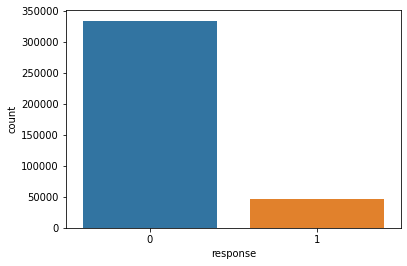

In [21]:
sns.countplot(x = 'response', data=df1)

Based on response descriptive statistical analysis, this variable (our target) is **unbalanced**.

- 87,7% is 0 (negative for interest)
- 12,3 is 1 (positive for interest)

This problem is not about an unbalanced problem as default. 

A balance techinic will be applied to solve this problem.

# 2.0 Feature Engineering And Variables Filtering

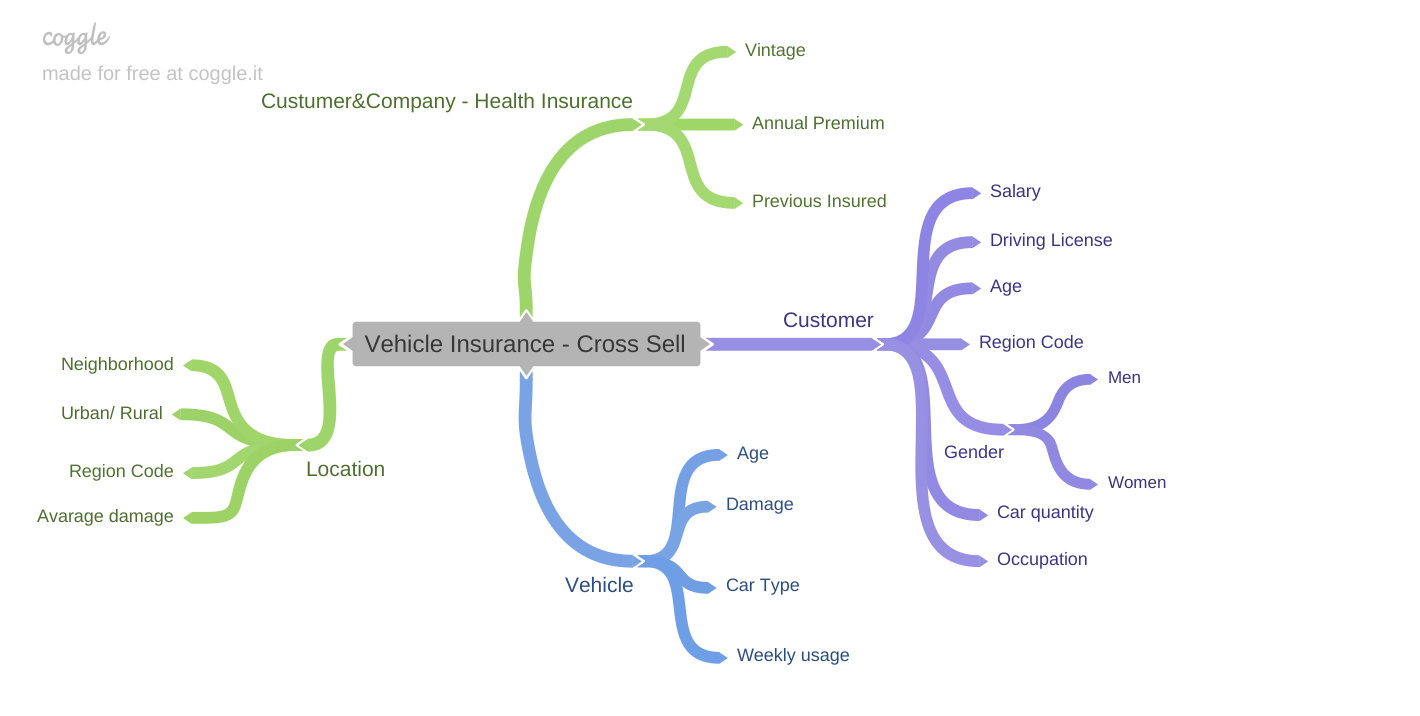

In [22]:
Image ('img/Vehicle_Insurance_Cross_Sell.png')

## 2.1 Hypotheses creation

### 2.1.1 Company's Hypotheses

 **1.** Interest is greater with customer's previous insured
 
 **2.** Interest is greater with customers that spend more than 30k/year with health insurance
 
 **3.** Interest is greater with customers with higher vintage - more than 150 days
****

### 2.1.2 Customer's Hypotheses

 **1.** Interest is greater with older people (more than 40 years)

 **2.** Interest is greater more with female than male (%)

 **3.** Interest is greater with driving license customers
 
 **4.** Interest is greater with customers that have more than one vehicle
 
 **5.** Interest is greater with customers that earn more than $75k/year

****

### 2.1.3 Vehicle's Hypotheses

 **1.** Interest is greater with new vehicles (less than 1 year) 

 **2.** Interest is greater with customer's vehicles previously damaged

 **3.** Interest is greater with customers that use vehicle more than 3 times per week

 **4.** Interest is greater with customers that own sport vehicles
 
****

### 2.1.4 Location's Hypotheses

 **1.** Interest is greater with costumer's violent neighborhood

 **2.** Interest is greater with costumers that live in urban location

 **3.** Interest is greater with costumers that live in a higher avarage damage city


****

## 2.2 Creating New Features

In [23]:
df2 = df1.copy()

In [24]:
#Creating new features


#mapping vechicle_damage from NO to 0 and Yes to 1
vehicle_damage_mapping = {'No':0,
                          'Yes':1}
df2['vehicle_damage'] = df2['vehicle_damage'].map(vehicle_damage_mapping)

#annual_premium paid per day
df2['annual_premium_per_day'] = df2['annual_premium']/df2['vintage']

#annual_premium divided per age
df2['annual_premium_per_age'] = df2['annual_premium']/df2['age']

#vintage_per_age
df2['vintage_per_age'] = df2['vintage']/df2['age']

#logic between previously_insured  and vehicle_damage
df2['previously_insured_vehicle_damage'] =  df2.apply(lambda row: -(row['vehicle_damage'] + row['previously_insured'])**2 if row['previously_insured'] == 0 else (row['vehicle_damage'] + row['previously_insured'])**2, axis=1)

#logic between vehicle_age (consider age > 1 as 1 and age < 1 as 0) and vehicle_damage
df2['vehicle_age_vehicle_damage'] = df2.apply(lambda row: -((row['vehicle_damage'] + 0)**2) if row['vehicle_age'] == '<1 Year' else (row['vehicle_damage'] + 1)**2, axis=1)

#logic between driving_license and vehicle_damage
df2['vehicle_damage_license'] = df2.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)

#logic between annual_premium divided per mean of annual_premium per region_code
df2_annual_premium_mean_region_code = df2.rename(columns={'annual_premium': 'annual_premium_mean'}).groupby('region_code').mean()
df2_annual_premium_mean_region_code.reset_index(inplace=True)
df2 = df2.merge(df2_annual_premium_mean_region_code[['region_code', 'annual_premium_mean']], on='region_code', how='left')
df2['annual_premium_per_ap_mean_rc'] = df2.apply(lambda row: (row['annual_premium']/row['annual_premium_mean']) ,axis=1)
df2.drop(columns='annual_premium_mean', inplace = True)
df2_annual_premium_mean_region_code = None

#logic between annual_premium divided per mean of annual_premium per policy_sales_channel
df2_annual_premium_mean_policy_sales_channel = df2.rename(columns={'annual_premium': 'annual_premium_mean'}).groupby('policy_sales_channel').mean()
df2_annual_premium_mean_policy_sales_channel.reset_index(inplace=True)
df2 = df2.merge(df2_annual_premium_mean_policy_sales_channel[['policy_sales_channel', 'annual_premium_mean']], on='policy_sales_channel', how='left')
df2['annual_premium_per_ap_mean_psc'] = df2.apply(lambda row: (row['annual_premium']/row['annual_premium_mean']) ,axis=1)
df2.drop(columns='annual_premium_mean', inplace = True)
df2_annual_premium_mean_policy_sales_channel = None

#logic of vehicle_damage_mean per region_code
df2_vehicle_damage_mean_per_region_code = df2.rename(columns={'vehicle_damage': 'vehicle_damage_mean_region_code'}).groupby('region_code').mean()
df2_vehicle_damage_mean_per_region_code.reset_index(inplace=True)
df2 = df2.merge(df2_vehicle_damage_mean_per_region_code[['region_code', 'vehicle_damage_mean_region_code']], on='region_code', how='left')

num_attributes = df2[['age', 'annual_premium', 'vintage', 'annual_premium_per_day', 
                         'annual_premium_per_age', 'vintage_per_age',
                         'annual_premium_per_ap_mean_rc', 'annual_premium_per_ap_mean_psc',
                         'vehicle_damage_mean_region_code']]

cat_attributes = df2[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age',
                      'gender', 'region_code', 'policy_sales_channel', 'vehicle_age_vehicle_damage', 
                      'vehicle_damage_license', 'previously_insured_vehicle_damage']]

# 3.0 Exploratory Data Analysis (EDA)

In [25]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Numerical Attributes

#### 3.1.1.1 Age

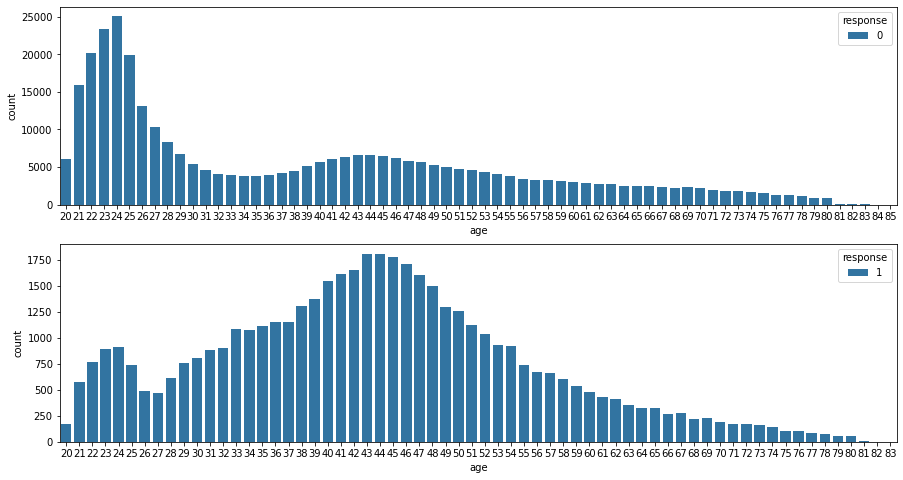

In [26]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'age', data=df3[df3['response']==0], hue='response',ax=axs[0]);
sns.countplot(x = 'age', data=df3[df3['response']==1], hue='response',ax=axs[1]);

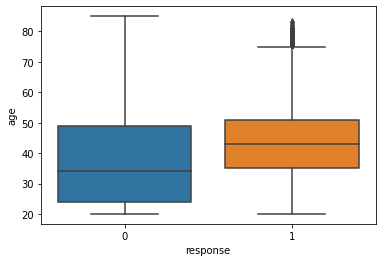

In [27]:
sns.boxplot(x= 'response', y='age', data=df3);

#### 3.1.1.2 Annual Premium

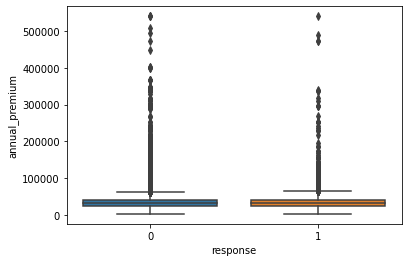

In [28]:
sns.boxplot(x= 'response', y='annual_premium', data=df3);

In [29]:
aux1=df3[(df3['annual_premium']<100000)&(df3['annual_premium']>3000)&(df3['response']==0)]
aux2=df3[(df3['annual_premium']<100000)&(df3['annual_premium']>3000)&(df3['response']==1)]
aux3=df3[(df3['annual_premium']<65000)&(df3['annual_premium']>5000)]

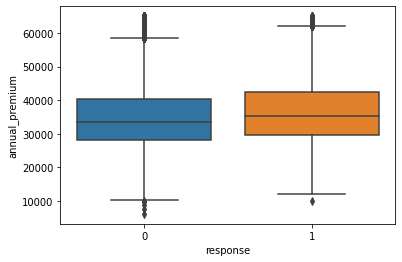

In [30]:
sns.boxplot(x= 'response', y='annual_premium', data=aux3);

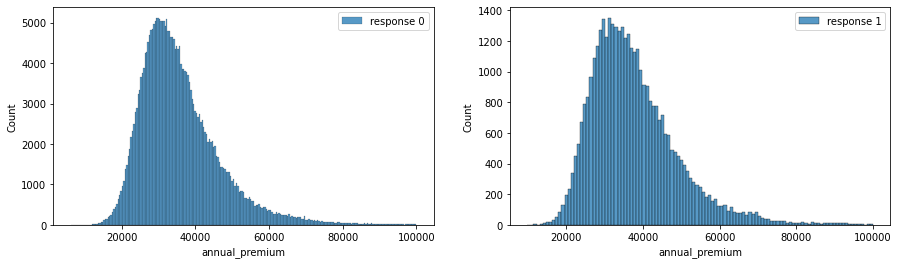

In [31]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(aux1['annual_premium'],kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['response 0'])
sns.histplot(aux2['annual_premium'],kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['response 1'])

#### 3.1.1.3 Vintage

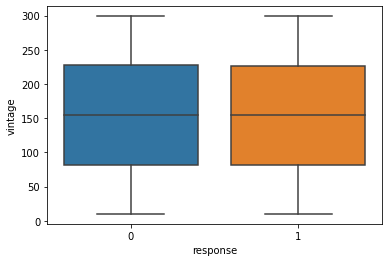

In [32]:
sns.boxplot(x= 'response', y='vintage', data=df3);

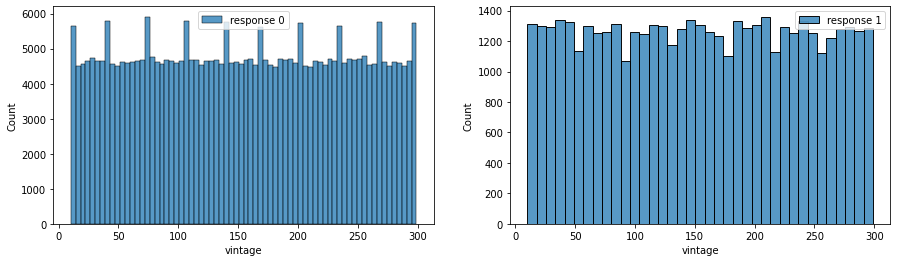

In [33]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[df3['response']==0]['vintage'],kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['response 0'])
sns.histplot(df3[df3['response']==1]['vintage'],kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['response 1'])

#### 3.1.1.4 Annual Premium per day

In [34]:
aux4= df3[df3['annual_premium_per_day']<1000]

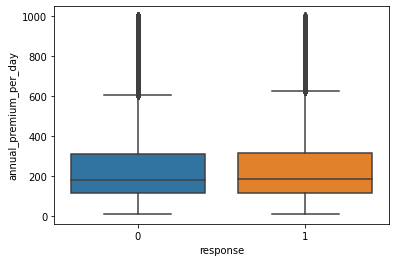

In [35]:
sns.boxplot(x= 'response', y='annual_premium_per_day', data=aux4);

#### 3.1.1.5 Annual Premium per age

In [36]:
aux5= df3[df3['annual_premium_per_age']<2500]

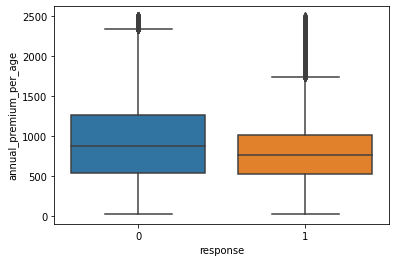

In [37]:
sns.boxplot(x= 'response', y='annual_premium_per_age', data=aux5);

#### 3.1.1.6 Vintage per age

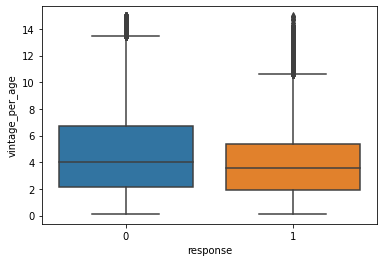

In [38]:
sns.boxplot(x= 'response', y='vintage_per_age', data=df3);

#### 3.1.1.7 Annual premium per region code annual premium mean 

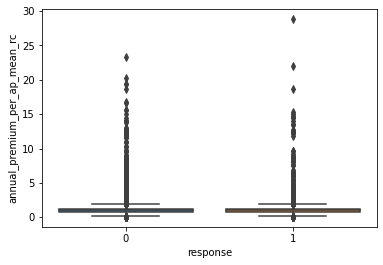

In [39]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_rc', data=df3);

In [40]:
aux6=df3[(df3['annual_premium_per_ap_mean_rc']<2)&(df3['annual_premium_per_ap_mean_rc']>1)]

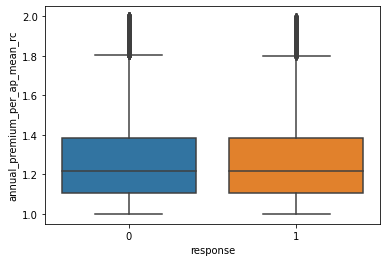

In [41]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_rc', data=aux6);

#### 3.1.1.8 Annual premium per policy sales channel annual premium mean 

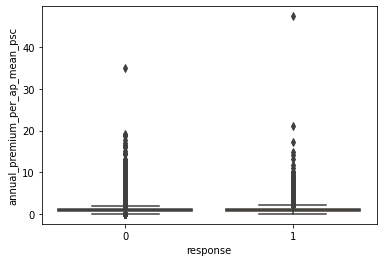

In [42]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_psc', data=df3);

In [43]:
aux7=df3[(df3['annual_premium_per_ap_mean_psc']<2)&(df3['annual_premium_per_ap_mean_psc']>1)]

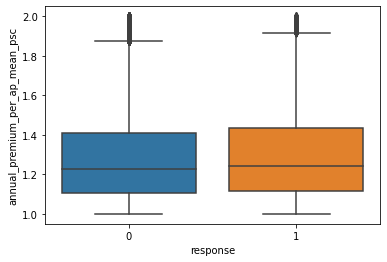

In [44]:
sns.boxplot(x= 'response', y='annual_premium_per_ap_mean_psc', data=aux7);

#### 3.1.1.9 Vehicle damage mean per region code

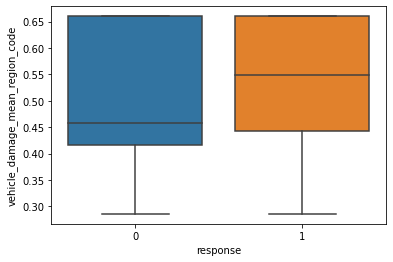

In [45]:
sns.boxplot(x= 'response', y='vehicle_damage_mean_region_code', data=df3);

### 3.1.2 Categorical Attributes

#### 3.1.2.1 Driving License

<AxesSubplot:xlabel='driving_license', ylabel='count'>

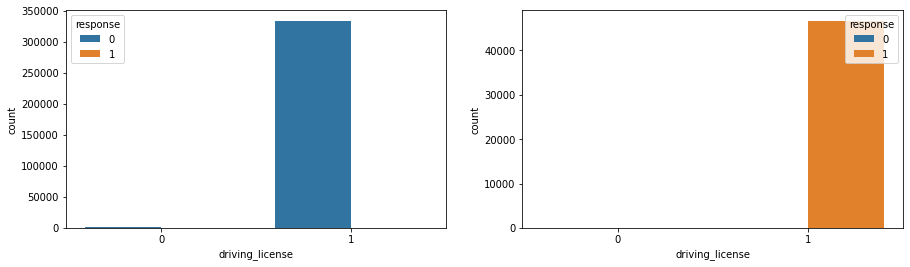

In [46]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['driving_license'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['driving_license'], hue=df3['response'], ax=axs[1])

In [47]:
pd.crosstab(df3['driving_license'], df3['response'])

response,0,1
driving_license,,
0,771,41
1,333628,46669


#### 3.1.2.2 Previously insured

<AxesSubplot:xlabel='previously_insured', ylabel='count'>

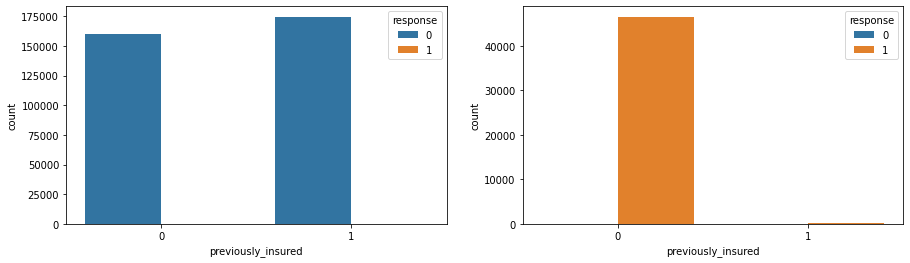

In [48]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['previously_insured'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['previously_insured'], hue=df3['response'], ax=axs[1])

In [49]:
pd.crosstab(df3['previously_insured'], df3['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


#### 3.1.2.3 Vehicle damage

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

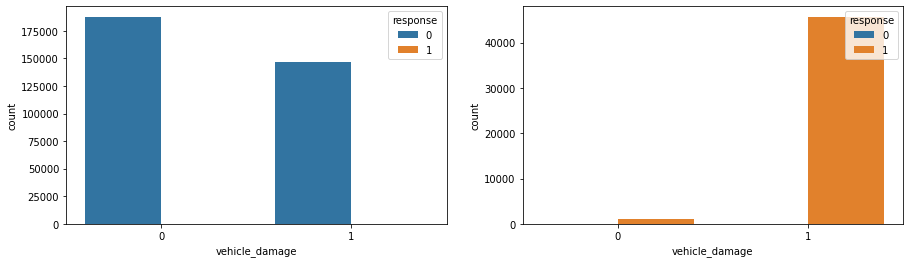

In [50]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_damage'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_damage'], hue=df3['response'], ax=axs[1])

In [51]:
aux8 = pd.crosstab(df3['vehicle_damage'], df3['response'])
aux8['percent'] = aux8[1]/(aux8[1]+aux8[0])
aux8

response,0,1,percent
vehicle_damage,,,
0,187714,982,0.005204
1,146685,45728,0.237655


#### 3.1.2.4 Vehicle age

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

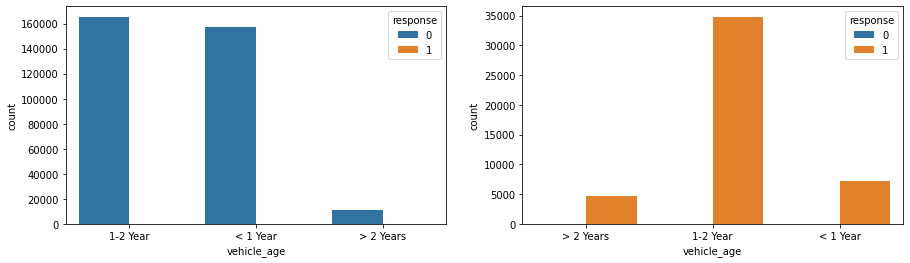

In [52]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_age'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_age'], hue=df3['response'], ax=axs[1])

In [53]:
aux9=pd.crosstab(df3['vehicle_age'], df3['response'])
aux9['percent'] = aux9[1]/(aux9[1]+aux9[0])
aux9

response,0,1,percent
vehicle_age,,,
1-2 Year,165510,34806,0.173755
< 1 Year,157584,7202,0.043705
> 2 Years,11305,4702,0.293746


#### 3.1.2.5 Gender

<AxesSubplot:xlabel='gender', ylabel='count'>

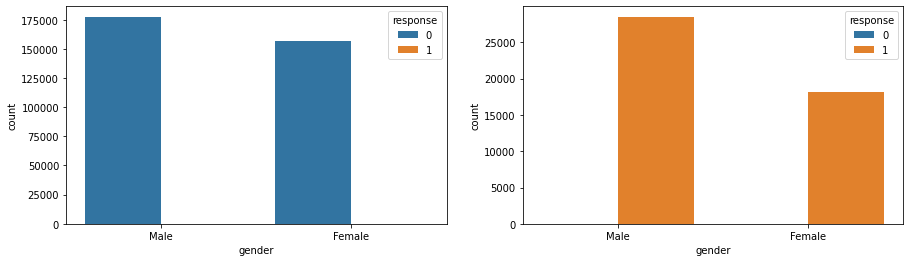

In [54]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['gender'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['gender'], hue=df3['response'], ax=axs[1])

In [55]:
aux10=pd.crosstab(df3['gender'], df3['response'])
aux10['percent'] = aux10[1]/(aux10[1]+aux10[0])
aux10

response,0,1,percent
gender,,,
Female,156835,18185,0.103902
Male,177564,28525,0.138411


#### 3.1.2.6 Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

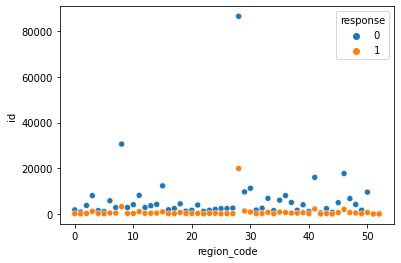

In [56]:
#fig, axs = plt.subplots(figsize = (15,4))
aux11 = df3[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x= 'region_code', y='id', hue='response', data=aux11)

#### 3.1.2.7 Policy sales channel

<AxesSubplot:xlabel='policy_sales_channel', ylabel='id'>

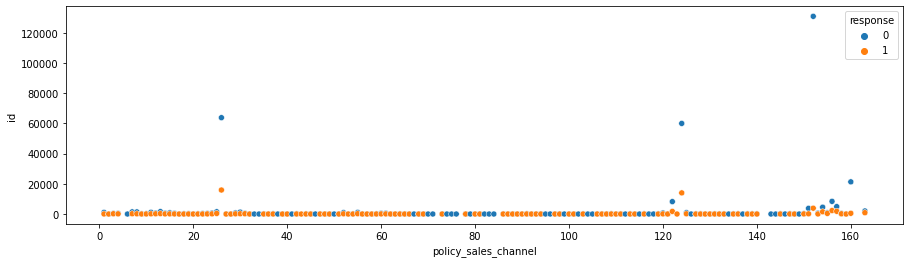

In [57]:
fig, axs = plt.subplots(figsize = (15,4))
aux11 = df3[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sns.scatterplot(x= 'policy_sales_channel', y='id', hue='response', data=aux11)

#### 3.1.2.8 Vehicle age & vehicle damage

<AxesSubplot:xlabel='vehicle_age_vehicle_damage', ylabel='count'>

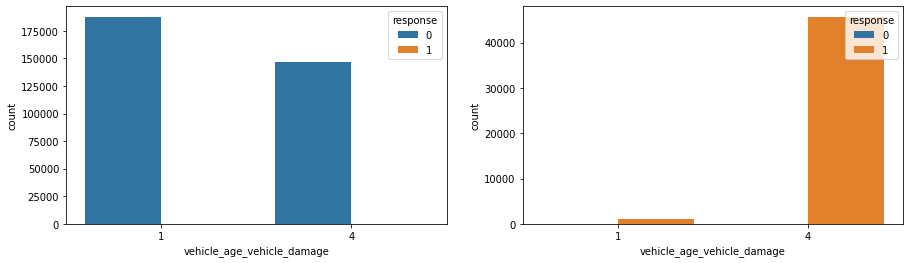

In [58]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_age_vehicle_damage'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_age_vehicle_damage'], hue=df3['response'], ax=axs[1])

In [59]:
aux12=pd.crosstab(df3['vehicle_age_vehicle_damage'], df3['response'])
aux12['percent'] = aux12[1]/(aux12[1]+aux12[0])
aux12

response,0,1,percent
vehicle_age_vehicle_damage,,,
1,187714,982,0.005204
4,146685,45728,0.237655


#### 3.1.2.9 Vehicle damage & driving license

<AxesSubplot:xlabel='vehicle_damage_license', ylabel='count'>

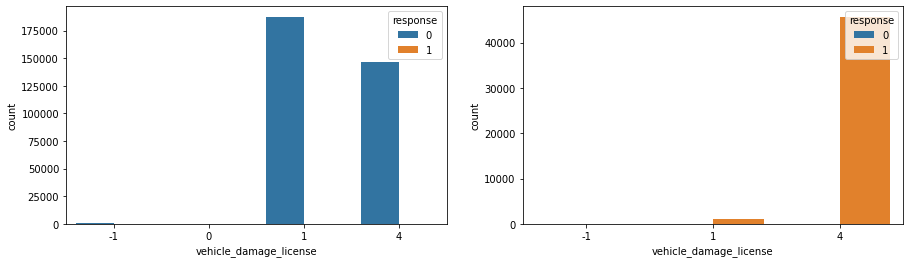

In [60]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['vehicle_damage_license'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['vehicle_damage_license'], hue=df3['response'], ax=axs[1])

In [61]:
aux13=pd.crosstab(df3['vehicle_damage_license'], df3['response'])
aux13['percent'] = aux13[1]/(aux13[1]+aux13[0])
aux13

response,0,1,percent
vehicle_damage_license,,,
-1,515,41,0.073741
0,256,0,0.000000
1,187458,982,0.005211
4,146170,45687,0.238130


#### 3.1.2.10 Previously insured & vehicle damage

<AxesSubplot:xlabel='previously_insured_vehicle_damage', ylabel='count'>

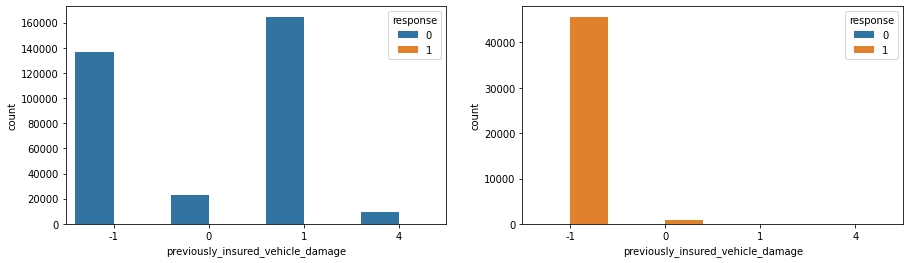

In [62]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(df3[df3['response']==0]['previously_insured_vehicle_damage'], hue=df3['response'], ax=axs[0])
sns.countplot(df3[df3['response']==1]['previously_insured_vehicle_damage'], hue=df3['response'], ax=axs[1])

In [63]:
aux14=pd.crosstab(df3['previously_insured_vehicle_damage'], df3['response'])
aux14['percent'] = aux14[1]/(aux14[1]+aux14[0])
aux14

response,0,1,percent
previously_insured_vehicle_damage,,,
-1,136849,45642,0.250105
0,23080,910,0.037932
1,164634,72,0.000437
4,9836,86,0.008668


### 3.1.3 Response Variable

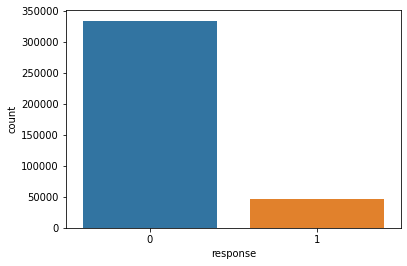

In [64]:
sns.countplot('response', data=df3);

## 3.2 Bivariate Analysis

### 3.2.1 Interest is greater with customer's previous insured

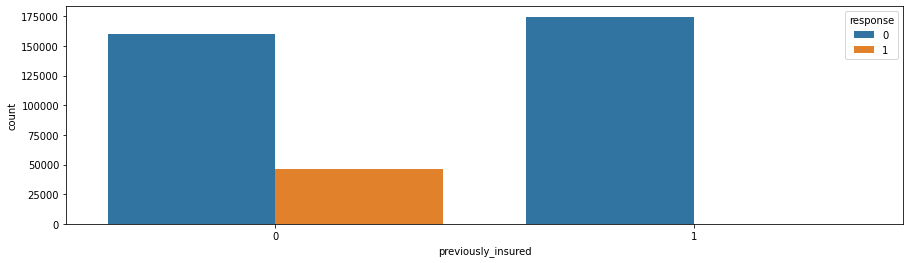

In [65]:
fig, axs = plt.subplots( figsize = (15,4))
sns.countplot(df3['previously_insured'], hue=df3['response']);

In [66]:
aux15 = pd.crosstab(df3['previously_insured'], df3['response'])
aux15['percent %'] = aux15[1]/(aux15[0]+aux15[1])*100 
aux15

response,0,1,percent %
previously_insured,,,
0,159929,46552,22.545416
1,174470,158,0.090478


Hypothesis **FALSE**
- 22,54% has interest in vehicle insurance and is not insured yet
- 0,09% has interest in vehicle insurance and is insured

### 3.2.2 Interest is greater with customers that spend more than 30k/year with health insurance

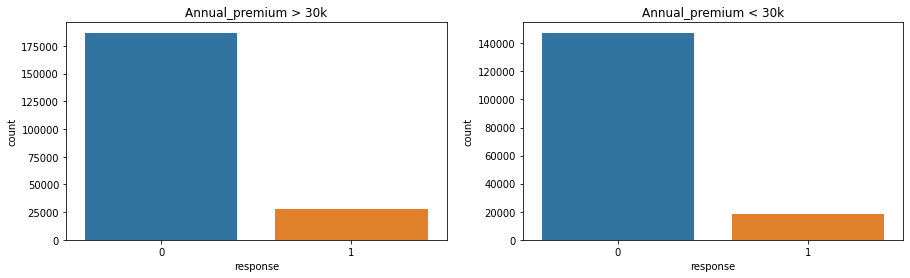

In [67]:
aux16 = df3[df3['annual_premium']>30000][['id','response']]
aux17 = df3[df3['annual_premium']<=30000][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux16['response'], ax=axs[0]).set_title('Annual_premium > 30k')
sns.countplot(aux17['response'], ax=axs[1]).set_title('Annual_premium < 30k');

In [68]:
print('% Interested in vehicle insurance that spent more than 30k/year: {0:.2f}'.format(100*(aux16[aux16['response']==1]['response'].count()/(aux16[aux16['response']==1]['response'].count()+aux16[aux16['response']==0]['response'].count()))))
print('% Interested in vehicle insurance that spent less than 30k/year: {0:.2f}'.format(100*(aux17[aux17['response']==1]['response'].count()/(aux17[aux17['response']==1]['response'].count()+aux17[aux17['response']==0]['response'].count()))))

% Interested in vehicle insurance that spent more than 30k/year: 13.10
% Interested in vehicle insurance that spent less than 30k/year: 11.16


Hypothesis **TRUE**
- 13,10% has interest in vehicle insurance and spent more than 30k per year in health insurance
- 11,16% has interest in vehicle insurance and spent less than 30k per year in health insurance

### 3.2.3 Interest is greater with customers with higher vintage - more than 150 days

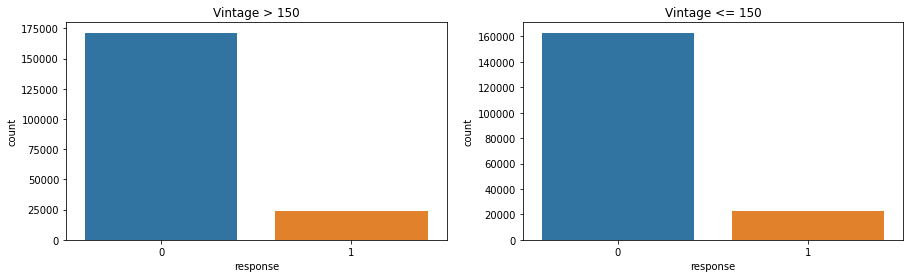

In [69]:
aux18 = df3[df3['vintage']>150][['id','response']]
aux19 = df3[df3['vintage']<=150][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux18['response'], ax=axs[0]).set_title('Vintage > 150')
sns.countplot(aux19['response'], ax=axs[1]).set_title('Vintage <= 150');

In [70]:
print('% Interested in vehicle insurance that is health insured more than 150 days: {0:.2f}'.format(100*(aux18[aux18['response']==1]['response'].count()/(aux18[aux18['response']==1]['response'].count()+aux18[aux18['response']==0]['response'].count()))))
print('% Interested in vehicle insurance that is health insured less than 150 days: {0:.2f}'.format(100*(aux19[aux19['response']==1]['response'].count()/(aux19[aux19['response']==1]['response'].count()+aux19[aux19['response']==0]['response'].count()))))

% Interested in vehicle insurance that is health insured more than 150 days: 12.24
% Interested in vehicle insurance that is health insured less than 150 days: 12.28


Hypothesis **FALSE**
- 12,24% has interest in vehicle insurance and is health insured more than 150 days
- 12,28% has interest in vehicle insurance and is health insured less than 150 days

### 3.2.4 Interest is greater with older people (more than 40 years)

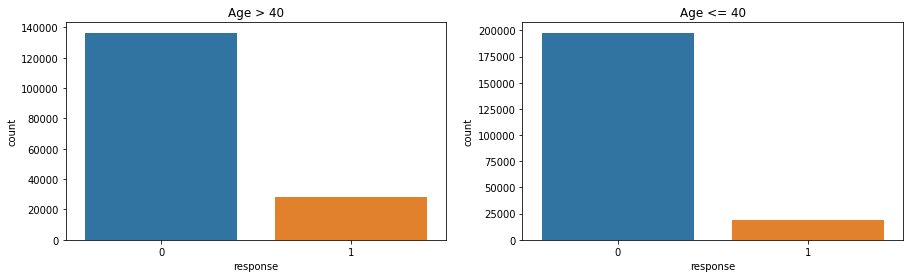

In [71]:
aux20 = df3[df3['age']>40][['id','response']]
aux21 = df3[df3['age']<=40][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux20['response'], ax=axs[0]).set_title('Age > 40')
sns.countplot(aux21['response'], ax=axs[1]).set_title('Age <= 40');

In [72]:
print('% Interested in vehicle insurance for people + 40 years old: {0:.2f}'.format(100*(aux20[aux20['response']==1]['response'].count()/(aux20[aux20['response']==1]['response'].count()+aux20[aux20['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for people - 40 years old: {0:.2f}'.format(100*(aux21[aux21['response']==1]['response'].count()/(aux21[aux21['response']==1]['response'].count()+aux21[aux21['response']==0]['response'].count()))))

% Interested in vehicle insurance for people + 40 years old: 16.98
% Interested in vehicle insurance for people - 40 years old: 8.67


Hypothesis **TRUE**
- 16,98% has interest in vehicle insurance and has more than 40 years old
- 8,67% has interest in vehicle insurance and has less than 40 years old

### 3.2.5 Interest is greater more with female than male (%)

<AxesSubplot:xlabel='gender', ylabel='count'>

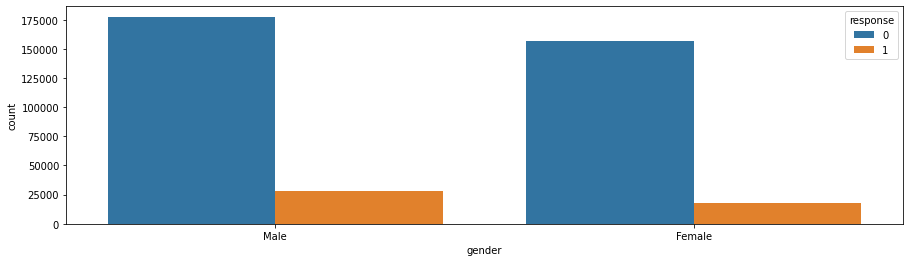

In [73]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x= df3['gender'], hue=df3['response'])

In [74]:
aux22=pd.crosstab(df3['gender'], df3['response'])
aux22['percent'] = aux22[1]/(aux22[1]+aux22[0])
aux22

response,0,1,percent
gender,,,
Female,156835,18185,0.103902
Male,177564,28525,0.138411


Hypothesis **FALSE**
- 10,39% of female has interest in vehicle insurance
- 13,84% of male has interest in vehicle insurance

### 3.2.6 Interest is greater with new vehicles (less than 1 year) 

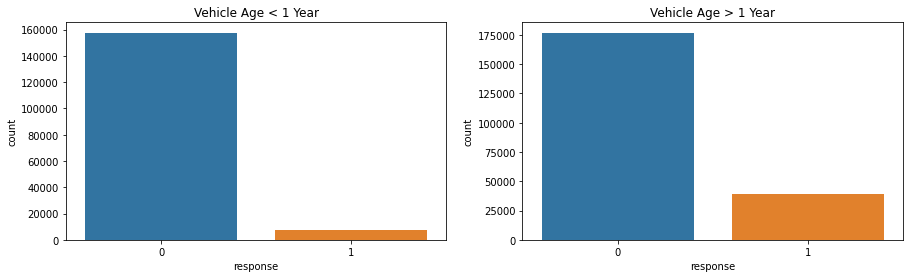

In [75]:
aux23 = df3[df3['vehicle_age']=='< 1 Year'][['id','response']]
aux24 = df3[df3['vehicle_age']!='< 1 Year'][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux23['response'], ax=axs[0]).set_title('Vehicle Age < 1 Year')
sns.countplot(aux24['response'], ax=axs[1]).set_title('Vehicle Age > 1 Year');

In [76]:
print('% Interested in vehicle insurance for people own new vehicles (less than 1 year): {0:.2f}'.format(100*(aux23[aux23['response']==1]['response'].count()/(aux23[aux23['response']==1]['response'].count()+aux23[aux23['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for people own "old" vehicles (more than 1 year): {0:.2f}'.format(100*(aux24[aux24['response']==1]['response'].count()/(aux24[aux24['response']==1]['response'].count()+aux24[aux24['response']==0]['response'].count()))))

% Interested in vehicle insurance for people own new vehicles (less than 1 year): 4.37
% Interested in vehicle insurance for people own "old" vehicles (more than 1 year): 18.26


Hypothesis **FALSE**
- 4,37% of new vehicle's owner has interest in vehicle insurance
- 18,26% of "old" vehicle's owner has interest in vehicle insurance

### 3.2.7 Interest is greater with customer's vehicles previously damaged

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

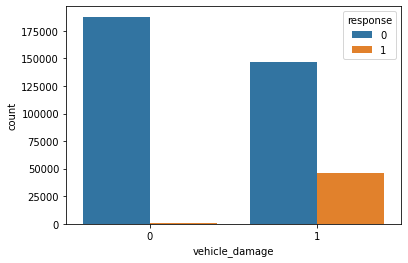

In [77]:
sns.countplot(df3['vehicle_damage'], hue=df3['response'])

In [78]:
aux8

response,0,1,percent
vehicle_damage,,,
0,187714,982,0.005204
1,146685,45728,0.237655


Hypothesis **TRUE**
- 0,52% of people does not has a previously vehicle damage has interest in vehicle insurance
- 23,77% of vehicle's previously damaged owner has interest in vehicle insurance

### 3.2.8 Interest is greater with costumers that live in a higher avarage damage city (higher than 50%)

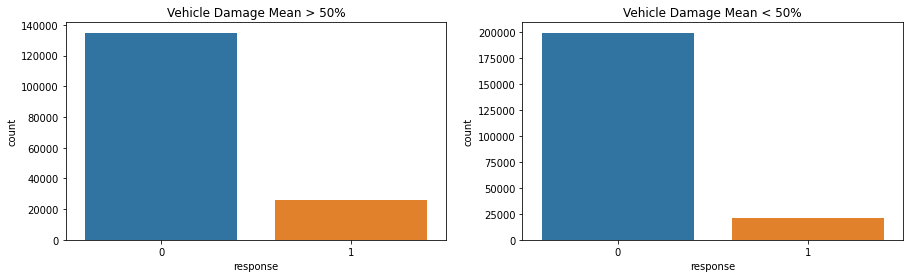

In [79]:
aux25 = df3[df3['vehicle_damage_mean_region_code']>0.5][['id','response']]
aux26 = df3[df3['vehicle_damage_mean_region_code']<0.5][['id','response']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux25['response'], ax=axs[0]).set_title('Vehicle Damage Mean > 50%')
sns.countplot(aux26['response'], ax=axs[1]).set_title('Vehicle Damage Mean < 50%');

In [80]:
print('% Interested in vehicle insurance for high average damage region code: {0:.2f}'.format(100*(aux25[aux25['response']==1]['response'].count()/(aux25[aux25['response']==1]['response'].count()+aux25[aux25['response']==0]['response'].count()))))
print('% Interested in vehicle insurance for low average damage region code: {0:.2f}'.format(100*(aux26[aux26['response']==1]['response'].count()/(aux26[aux26['response']==1]['response'].count()+aux26[aux26['response']==0]['response'].count()))))

% Interested in vehicle insurance for high average damage region code: 16.07
% Interested in vehicle insurance for low average damage region code: 9.48


Hypothesis **TRUE**
- 16.07% of people lives in a high average vehicle damage city hasinterest in vehicle insurance
- 23,77% of people lives in a low average vehicle damage city hasinterest in vehicle insurance

## 3.3 Multivariable Analysis

### 3.3.1 Numerical Attributes

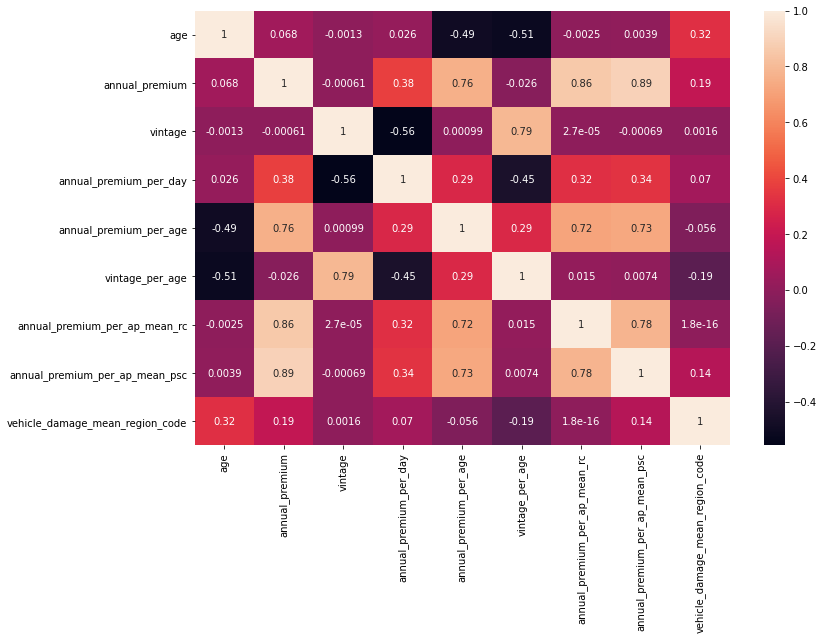

In [81]:
fig = plt.subplots(figsize = (12,8))
sns.heatmap(num_attributes.corr(), annot = True);

### 3.3.1 Categorical Attributes

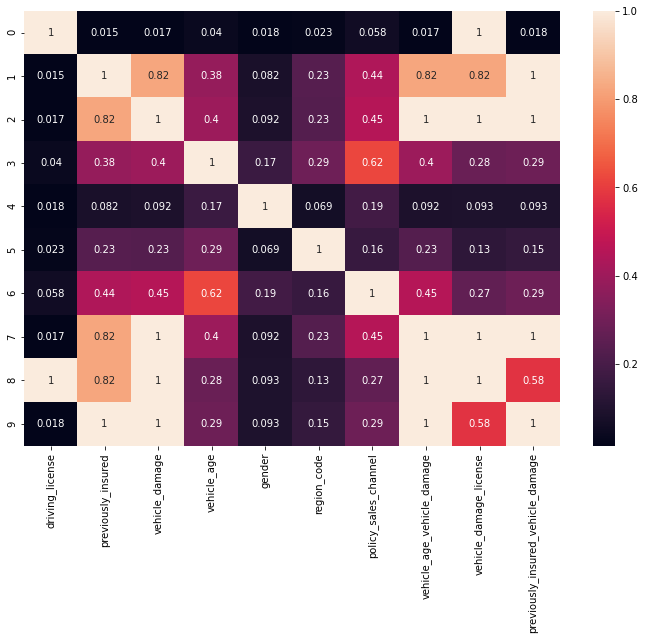

In [82]:
fig = plt.subplots(figsize = (12,8))
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

## 3.4 Hypothesis conclusion 

In [83]:
hyp_conclu = pd.DataFrame(columns= ['Hypothesis', 'True/False', 'Relevance'])

hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H1 - Interest is greater with customers previous insured', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H2 - Interest is greater with customers that spend more than 30k/year with health insurance', 'True', 'Low'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H3 - Interest is greater with customers with higher vintage - more than 150 days', 'False', 'Low'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H4 - Interest is greater with older people (more than 40 years)', 'True', 'Medium'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H5 - Interest is greater more with female than male', 'False', 'Low'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H6 - Interest is greater with new vehicles (less than 1 year) ', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H7 - Interest is greater with customers vehicles previously damaged', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H8 - Interest is greater with costumers that live in a higher avarage damage city (higher than 50%)', 'True', 'Medium'])), ignore_index=True)
pd.set_option('display.max_colwidth', 120)
hyp_conclu

,Hypothesis,True/False,Relevance
0,H1 - Interest is greater with customers previous insured,False,High
1,H2 - Interest is greater with customers that spend more than 30k/year with health insurance,True,Low
2,H3 - Interest is greater with customers with higher vintage - more than 150 days,False,Low
3,H4 - Interest is greater with older people (more than 40 years),True,Medium
4,H5 - Interest is greater more with female than male,False,Low
5,H6 - Interest is greater with new vehicles (less than 1 year),False,High
6,H7 - Interest is greater with customers vehicles previously damaged,True,High
7,H8 - Interest is greater with costumers that live in a higher avarage damage city (higher than 50%),True,Medium


# 4.0 Data Preparation

In [84]:
df3.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'annual_premium_per_day', 'annual_premium_per_age', 'vintage_per_age',
       'previously_insured_vehicle_damage', 'vehicle_age_vehicle_damage',
       'vehicle_damage_license', 'annual_premium_per_ap_mean_rc',
       'annual_premium_per_ap_mean_psc', 'vehicle_damage_mean_region_code'],
      dtype='object')

## 4.1 Split data to train and validation data

In [85]:
X = df3.drop(['response'], axis = 1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.2)

df4 = pd.concat([x_train, y_train], axis = 1)

## 4.2 Standarlization

In [86]:
ss_annual_premium = pp.StandardScaler()
ss_annual_premium_per_day = pp.StandardScaler()
ss_annual_premium_per_age = pp.StandardScaler()
ss_annual_premium_per_ap_mean_rc = pp.StandardScaler()
ss_annual_premium_per_ap_mean_psc = pp.StandardScaler()

# annual_premium
df4['annual_premium'] = ss_annual_premium.fit_transform(df4[['annual_premium']].values)

# annual_premium_per_day
df4['annual_premium_per_day'] = ss_annual_premium_per_day.fit_transform(df4[['annual_premium_per_day']].values)

# annual_premium_per_age
df4['annual_premium_per_age'] = ss_annual_premium_per_age.fit_transform(df4[['annual_premium_per_age']].values)

# annual_premium_per_ap_mean_rc
df4['annual_premium_per_ap_mean_rc'] = ss_annual_premium_per_ap_mean_rc.fit_transform(df4[['annual_premium_per_ap_mean_rc']].values)

# annual_premium_per_ap_mean_psc
df4['annual_premium_per_ap_mean_psc'] = ss_annual_premium_per_ap_mean_psc.fit_transform(df4[['annual_premium_per_ap_mean_psc']].values)

## 4.3 Rescaling

In [87]:
mms_vintage = pp.MinMaxScaler()
mms_age = pp.MinMaxScaler()
mms_vintage_per_age = pp.MinMaxScaler()
mms_vehicle_damage_mean_region_code = pp.MinMaxScaler()

# vintage
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)

# age
df4['age'] = mms_age.fit_transform(df4[['age']].values)

# vintage_per_age
df4['vintage_per_age'] = mms_vintage_per_age.fit_transform(df4[['vintage_per_age']].values)

# vehicle_damage_mean_region_code
df4['vehicle_damage_mean_region_code'] = mms_vehicle_damage_mean_region_code.fit_transform(df4[['vehicle_damage_mean_region_code']].values)

## 4.4 Encoder

In [88]:
# gender
target_encode_gender = df4.groupby('gender')['response'].mean()
df4.loc[:,'gender'] = df4['gender'].map(target_encode_gender)

# region_code
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:,'region_code'] = df4['region_code'].map(target_encode_region_code)

# policy_sales_channel
fe_policy_sales_channel = df4.groupby('policy_sales_channel').size()/len(df4)
df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_sales_channel)

# vehicle_age
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])

# previously_insured_vehicle_damage
target_encode_previously_insured_vehicle_damage = df4.groupby('previously_insured_vehicle_damage')['response'].mean()
df4.loc[:,'previously_insured_vehicle_damage'] = df4['previously_insured_vehicle_damage'].map(target_encode_previously_insured_vehicle_damage)

# vehicle_age_vehicle_damage
target_encode_vehicle_age_vehicle_damage = df4.groupby('vehicle_age_vehicle_damage')['response'].mean()
df4.loc[:,'vehicle_age_vehicle_damage'] = df4['vehicle_age_vehicle_damage'].map(target_encode_vehicle_age_vehicle_damage)

# vehicle_damage_license
target_encode_vehicle_damage_license = df4.groupby('vehicle_damage_license')['response'].mean()
df4.loc[:,'vehicle_damage_license'] = df4['vehicle_damage_license'].map(target_encode_vehicle_damage_license)

## 4.5 Validation preparation

In [89]:
# annual_premium
x_validation['annual_premium'] = ss_annual_premium.transform(x_validation[['annual_premium']].values)

# annual_premium_per_day
x_validation['annual_premium_per_day'] = ss_annual_premium_per_day.transform(x_validation[['annual_premium_per_day']].values)

# annual_premium_per_age
x_validation['annual_premium_per_age'] = ss_annual_premium_per_age.transform(x_validation[['annual_premium_per_age']].values)

# annual_premium_per_ap_mean_rc
x_validation['annual_premium_per_ap_mean_rc'] = ss_annual_premium_per_ap_mean_rc.transform(x_validation[['annual_premium_per_ap_mean_rc']].values)

# annual_premium_per_ap_mean_psc
x_validation['annual_premium_per_ap_mean_psc'] = ss_annual_premium_per_ap_mean_psc.transform(x_validation[['annual_premium_per_ap_mean_psc']].values)

# vintage
x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# age
x_validation['age'] = mms_age.transform(x_validation[['age']].values)

# vintage_per_age
x_validation['vintage_per_age'] = mms_vintage_per_age.transform(x_validation[['vintage_per_age']].values)

# vehicle_damage_mean_region_code
x_validation['vehicle_damage_mean_region_code'] = mms_vehicle_damage_mean_region_code.transform(x_validation[['vehicle_damage_mean_region_code']].values)

# gender
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].map(target_encode_gender)

# region_code
x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(target_encode_region_code)

# policy_sales_channel
x_validation.loc[:,'policy_sales_channel'] = x_validation.loc[:,'policy_sales_channel'].map(fe_policy_sales_channel)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# previously_insured_vehicle_damage
x_validation.loc[:,'previously_insured_vehicle_damage'] = x_validation.loc[:,'previously_insured_vehicle_damage'].map(target_encode_previously_insured_vehicle_damage)

# vehicle_age_vehicle_damage
x_validation.loc[:,'vehicle_age_vehicle_damage'] = x_validation.loc[:,'vehicle_age_vehicle_damage'].map(target_encode_vehicle_age_vehicle_damage)

# vehicle_damage_license
x_validation.loc[:,'vehicle_damage_license'] = x_validation.loc[:,'vehicle_damage_license'].map(target_encode_vehicle_damage_license)

x_validation = x_validation.dropna(axis=1)

## 4.5 Train preparation

In [90]:
x_train = df4.drop('response', axis =1)
y_train = df4['response']

# 5.0 Feature Selection

## 5.1 Boruta

In [91]:
x_train_b = x_train.values
y_train_b = y_train.values.ravel()

rf = RandomForestClassifier( n_jobs=-1)
boruta = BorutaPy(rf,n_estimators='auto',verbose=0,random_state=77).fit(x_train_b,y_train_b)

In [92]:
 #comentado para não fazer o algoritimo do boruta#
cols_selected = boruta.support_.tolist()

#colunas selecionadas
x_train_fs=x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#colunas não selecionadas
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print("BorutaSelected Column:")
cols_selected_boruta

BorutaSelected Column:


['previously_insured_vehicle_damage']

## 5.2 Feature importance

In [93]:
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs=-1)

x_train_n = df4.drop('response', axis =1)
y_train_n = y_train
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                             feature  importance
0                                 id    0.088441
0                                age    0.087549
0                    vintage_per_age    0.086585
0                            vintage    0.083982
0             annual_premium_per_day    0.083789
0             annual_premium_per_age    0.082326
0      annual_premium_per_ap_mean_rc    0.073699
0     annual_premium_per_ap_mean_psc    0.072949
0                     annual_premium    0.065350
0               policy_sales_channel    0.043454
0  previously_insured_vehicle_damage    0.041176
0                        region_code    0.036657
0    vehicle_damage_mean_region_code    0.034377
0             vehicle_damage_license    0.028845
0                     vehicle_damage    0.025737
0         vehicle_age_vehicle_damage    0.019947
0                 previously_insured    0.017503
0                             gender    0.011827
0               vehicle_age_< 1 Year    0.008023
0 

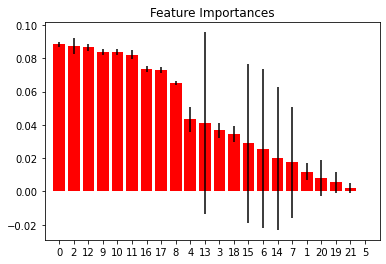

In [94]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i,j in zip(x_train_n, forest.feature_importances_):
    aux=pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df=pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance', ascending=False))

#plot the feature ranking
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

## 5.3 Hypothesis conclusion (from EDA)

In [95]:
hyp_conclu

,Hypothesis,True/False,Relevance
0,H1 - Interest is greater with customers previous insured,False,High
1,H2 - Interest is greater with customers that spend more than 30k/year with health insurance,True,Low
2,H3 - Interest is greater with customers with higher vintage - more than 150 days,False,Low
3,H4 - Interest is greater with older people (more than 40 years),True,Medium
4,H5 - Interest is greater more with female than male,False,Low
5,H6 - Interest is greater with new vehicles (less than 1 year),False,High
6,H7 - Interest is greater with customers vehicles previously damaged,True,High
7,H8 - Interest is greater with costumers that live in a higher avarage damage city (higher than 50%),True,Medium


## 5.4 Feature Selection Conclusion

- From Boruta:
    - age
- From Feature Importance:
    - vintage_per_age    
    - annual_premium_per_day    
    - vintage    
    - age    
    - annual_premium_per_age   
    - annual_premium_per_ap_mean_rc    
    - annual_premium_per_ap_mean_psc    
    - annual_premium
- From EDA:
    - previously_insured
    - vehicle_age
    - vehicle_damage
    - vehicle_damaged_mean_per_region_code
    - age

### 5.4.1 Final Feature Selection

In [167]:
 columns_selected = [   'age', 
                        'vintage_per_age', 
                        'annual_premium_per_day',
                        'vintage',    
                        'annual_premium_per_age',   
                        'annual_premium_per_ap_mean_rc',    
                        'annual_premium_per_ap_mean_psc',    
                        'annual_premium',
                        'previously_insured',
                        'vehicle_damage',
                        'vehicle_damage_mean_region_code']
    
x_train = x_train[ columns_selected]

x_val = x_validation[ columns_selected]
y_val = y_validation.copy()

# 6.0 Machine Learning Models

## 6.1 Logistic Regression model

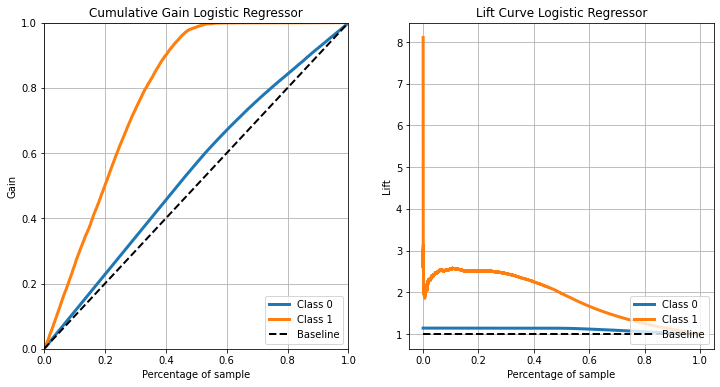

In [97]:
logreg_model = LogisticRegression(penalty='l2', solver='newton-cg')

model_reglog = logreg_model.fit(x_train,y_train)

yhat_proba_reglog = model_reglog.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_reglog, ax=axs[0],title='Cumulative Gain Logistic Regressor');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_reglog,ax=axs[1],title='Lift Curve Logistic Regressor');

In [102]:
x_validation['response'] = y_validation
precision_reglog = round(precision_at_k(x_validation, yhat_proba_reglog, 0.20),3)
recall_reglog= round(recall_at_k(x_validation, yhat_proba_reglog, 0.20),3)
f1_reglog = round(2*(precision_reglog*recall_reglog)/(precision_reglog+recall_reglog),3)
roc_reglog = round(m.roc_auc_score(y_validation,yhat_proba_reglog[:,1]),3)

print("Precision at k: {}" .format(precision_reglog))
print("Recall at k: {}" .format(recall_reglog))
print("F1-Score at k {}".format(f1_reglog))
print("ROC AUC Score {}".format(roc_reglog))

Precision at k: 0.309
Recall at k: 0.502
F1-Score at k 0.383
ROC AUC Score 0.83


In [103]:
models_performance = pd.DataFrame({'Model':['Logistic Regression'], "Precision_at_k": [precision_reglog], "Recall_at_k": [recall_reglog], "F1-Score_at_k": [f1_reglog], "ROC_AUC_Score": [roc_reglog]})

## 6.2 K Neighbors Classifier model

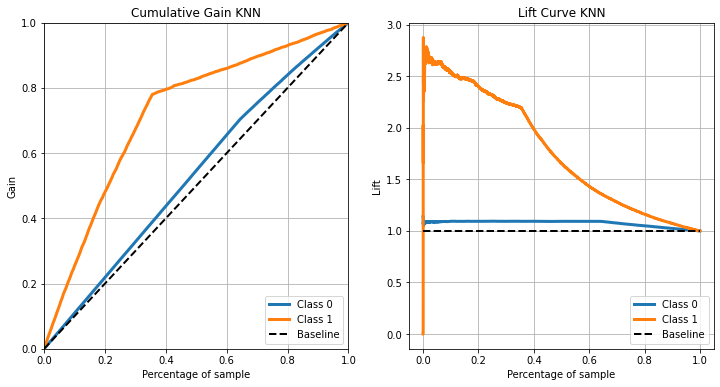

In [104]:
knn_model = KNeighborsClassifier(n_jobs=-1)

model_knn = knn_model.fit(x_train,y_train)

yhat_proba_knn = model_knn.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn, ax=axs[0],title='Cumulative Gain KNN');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_knn,ax=axs[1],title='Lift Curve KNN');

In [105]:
x_validation['response'] = y_validation
precision_knn = round(precision_at_k(x_validation, yhat_proba_knn, 0.20),3)
recall_knn= round(recall_at_k(x_validation, yhat_proba_knn, 0.20),3)
f1_knn = round(2*(precision_knn*recall_knn)/(precision_knn+recall_knn),3)
roc_knn = round(m.roc_auc_score(y_validation,yhat_proba_knn[:,1]),3)

print("Precision at k: {}" .format(precision_knn))
print("Recall at k: {}" .format(recall_knn))
print("F1-Score at k {}".format(f1_knn))
print("ROC AUC Score {}".format(roc_knn))

Precision at k: 0.297
Recall at k: 0.481
F1-Score at k 0.367
ROC AUC Score 0.753


In [106]:
models_performance = models_performance.append(pd.Series(['K Neighbors Classifier', precision_knn, recall_knn, f1_knn, roc_knn], index=models_performance.columns), ignore_index=True)

## 6.3 Random Forest Classifier model

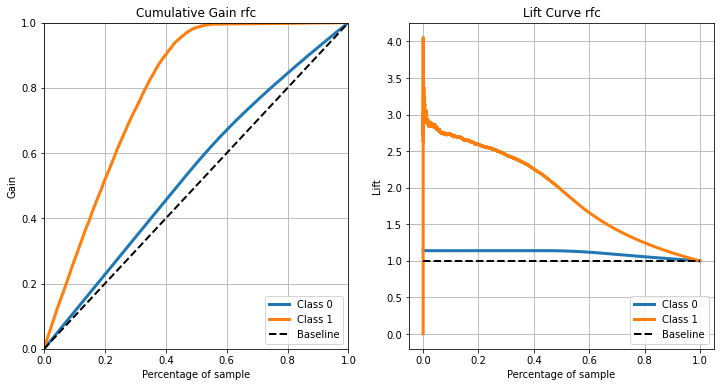

In [107]:
rfc_model = RandomForestClassifier(n_estimators=100,random_state=42)

model_rfc = rfc_model.fit(x_train,y_train)

yhat_proba_rfc = model_rfc.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rfc, ax=axs[0],title='Cumulative Gain rfc');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_rfc,ax=axs[1],title='Lift Curve rfc');

In [108]:
x_validation['response'] = y_validation
precision_rfc = round(precision_at_k(x_validation, yhat_proba_rfc, 0.20),3)
recall_rfc= round(recall_at_k(x_validation, yhat_proba_rfc, 0.20),3)
f1_rfc = round(2*(precision_rfc*recall_rfc)/(precision_rfc+recall_rfc),3)
roc_rfc = round(m.roc_auc_score(y_validation,yhat_proba_rfc[:,1]),3)

print("Precision at k: {}" .format(precision_rfc))
print("Recall at k: {}" .format(recall_rfc))
print("F1-Score at k {}".format(f1_rfc))
print("ROC AUC Score {}".format(roc_rfc))

Precision at k: 0.321
Recall at k: 0.52
F1-Score at k 0.397
ROC AUC Score 0.834


In [109]:
models_performance = models_performance.append(pd.Series(['Random Forest Classifier', precision_rfc, recall_rfc, f1_rfc, roc_rfc], index=models_performance.columns), ignore_index=True)

## 6.4 Naive Bayes Classifier model

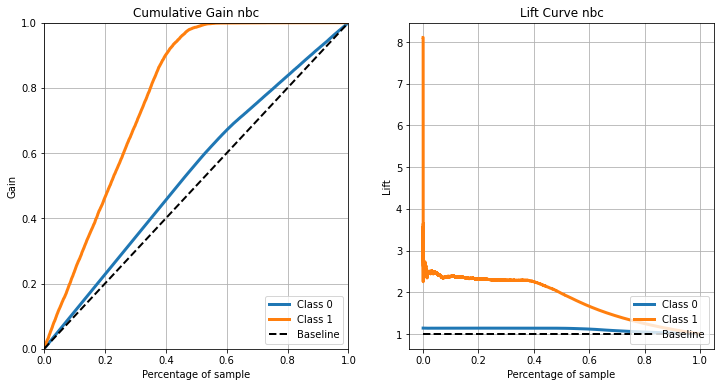

In [110]:
nbc_model = GaussianNB()

model_nbc = nbc_model.fit(x_train,y_train)

yhat_proba_nbc = model_nbc.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_nbc, ax=axs[0],title='Cumulative Gain nbc');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_nbc,ax=axs[1],title='Lift Curve nbc');

In [111]:
x_validation['response'] = y_validation
precision_nbc = round(precision_at_k(x_validation, yhat_proba_nbc, 0.20),3)
recall_nbc= round(recall_at_k(x_validation, yhat_proba_nbc, 0.20),3)
f1_nbc = round(2*(precision_nbc*recall_nbc)/(precision_nbc+recall_nbc),3)
roc_nbc = round(m.roc_auc_score(y_validation,yhat_proba_nbc[:,1]),3)

print("Precision at k: {}" .format(precision_nbc))
print("Recall at k: {}" .format(recall_nbc))
print("F1-Score at k {}".format(f1_nbc))
print("ROC AUC Score {}".format(roc_nbc))

Precision at k: 0.286
Recall at k: 0.464
F1-Score at k 0.354
ROC AUC Score 0.819


In [112]:
models_performance = models_performance.append(pd.Series(['Naive Bayes Classifier', precision_nbc, recall_nbc, f1_nbc, roc_nbc], index=models_performance.columns), ignore_index=True)

## 6.5 Light Gradient Boosting Machine Classifier model

<AxesSubplot:title={'center':'Lift Curve lgbm'}, xlabel='Percentage of sample', ylabel='Lift'>

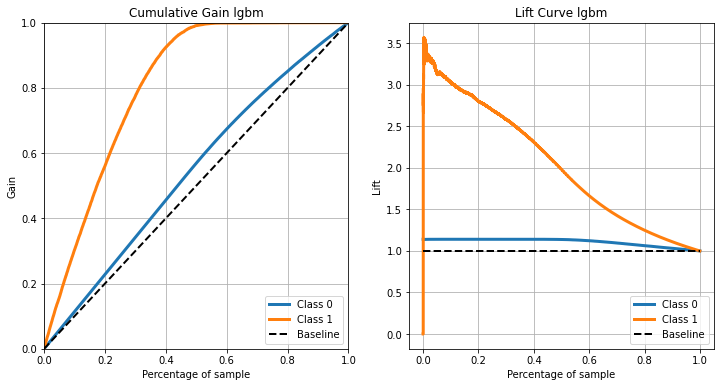

In [113]:
lgbm_model = LGBMClassifier()

model_lgbm = lgbm_model.fit(x_train,y_train)

yhat_proba_lgbm = model_lgbm.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm, ax=axs[0],title='Cumulative Gain lgbm');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm,ax=axs[1],title='Lift Curve lgbm')

In [114]:
x_validation['response'] = y_validation
precision_lgbm = round(precision_at_k(x_validation, yhat_proba_lgbm, 0.20),3)
recall_lgbm= round(recall_at_k(x_validation, yhat_proba_lgbm, 0.20),3)
f1_lgbm = round(2*(precision_lgbm*recall_lgbm)/(precision_lgbm+recall_lgbm),3)
roc_lgbm = round(m.roc_auc_score(y_validation,yhat_proba_lgbm[:,1]),3)

print("Precision at k: {}" .format(precision_lgbm))
print("Recall at k: {}" .format(recall_lgbm))
print("F1-Score at k {}".format(f1_lgbm))
print("ROC AUC Score {}".format(roc_lgbm))

Precision at k: 0.345
Recall at k: 0.56
F1-Score at k 0.427
ROC AUC Score 0.851


In [115]:
models_performance = models_performance.append(pd.Series(['Light GBM Classifier', precision_lgbm, recall_lgbm, f1_lgbm, roc_lgbm], index=models_performance.columns), ignore_index=True)

## 6.6 XGBoost Classifier model

<AxesSubplot:title={'center':'Lift Curve xgb'}, xlabel='Percentage of sample', ylabel='Lift'>

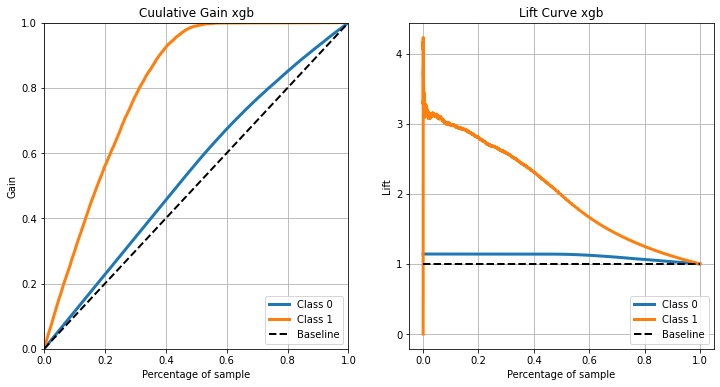

In [116]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')

model_xgb = xgb_model.fit(x_train,y_train)

yhat_proba_xgb = model_xgb.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_xgb, ax=axs[0],title='Cuulative Gain xgb');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_xgb,ax=axs[1],title='Lift Curve xgb')

In [117]:
x_validation['response'] = y_validation
precision_xgb = round(precision_at_k(x_validation, yhat_proba_xgb, 0.20),3)
recall_xgb= round(recall_at_k(x_validation, yhat_proba_xgb, 0.20),3)
f1_xgb = round(2*(precision_xgb*recall_xgb)/(precision_xgb+recall_xgb),3)
roc_xgb = round(m.roc_auc_score(y_validation,yhat_proba_xgb[:,1]),3)

print("Precision at k: {}" .format(precision_xgb))
print("Recall at k: {}" .format(recall_xgb))
print("F1-Score at k {}".format(f1_xgb))
print("ROC AUC Score {}".format(roc_xgb))

Precision at k: 0.346
Recall at k: 0.561
F1-Score at k 0.428
ROC AUC Score 0.85


In [118]:
models_performance = models_performance.append(pd.Series(['XGBoost Classifier', precision_xgb, recall_xgb, f1_xgb, roc_xgb], index=models_performance.columns), ignore_index=True)

In [119]:
models_performance.sort_values('F1-Score_at_k', ascending=False)

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
5,XGBoost Classifier,0.346,0.561,0.428,0.850
4,Light GBM Classifier,0.345,0.560,0.427,0.851
2,Random Forest Classifier,0.321,0.520,0.397,0.834
0,Logistic Regression,0.309,0.502,0.383,0.830
1,K Neighbors Classifier,0.297,0.481,0.367,0.753
3,Naive Bayes Classifier,0.286,0.464,0.354,0.819


## 6.7 Cross Validation

In [120]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [121]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Logistic Regression CV', logreg_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'K Neighbors Classifier CV', knn_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest Classifier CV', rfc_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Naive Bayes Classifier CV', nbc_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier CV', lgbm_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost Classifier CV', xgb_model, x_train, y_train)

In [122]:
models_performance_cv

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
0,Logistic Regression CV,0.303 +/- 0.0011,0.4952 +/- 0.0015,0.376 +/- 0.0011,0.8262 +/- 0.0012
1,K Neighbors Classifier CV,0.2918 +/- 0.002,0.4768 +/- 0.0029,0.3622 +/- 0.0025,0.7504 +/- 0.001
2,Random Forest Classifier CV,0.3112 +/- 0.0007,0.5086 +/- 0.0015,0.386 +/- 0.0011,0.828 +/- 0.0006
3,Naive Bayes Classifier CV,0.2804 +/- 0.0022,0.4586 +/- 0.0042,0.348 +/- 0.003,0.8148 +/- 0.0015
4,LightGBM Classifier CV,0.3404 +/- 0.0033,0.5568 +/- 0.0051,0.4226 +/- 0.004,0.8482 +/- 0.0012
5,XGBoost Classifier CV,0.3378 +/- 0.0037,0.552 +/- 0.006,0.419 +/- 0.0044,0.8462 +/- 0.0019


# 7.0 Hyperparameter tuning

## 7.1 XGBoost Classifier

In [123]:
def tune_xgb(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]
    reg_lambda        = params[7]
    reg_alpha         = params[8]
    

    #Model
    model = xgb.XGBClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_weight=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5], gamma=params[6], reg_lambda=params[7],reg_alpha=params[8],
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

    model.fit(x_train, y_train)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(x_val)

    # Prediction Proba
    yhat_proba = model.predict_proba(x_val)[:,1]
    # Performance
#     model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc = m.roc_auc_score(y_val, yhat_proba)
    
    return -roc



param = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_weight
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500), #n_estimetors
        (1.0, 6.0), #gamma
        (0, 9), #reg_lambda
        (40, 150)]#reg_alpha




result = forest_minimize(tune_xgb, param, random_state=42, n_random_starts=15, n_calls=15, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[0.006259548184287541, 1, 1, 0.4008609501227462, 0.7984250789732436, 221, 1.7799726016810133, 7, 139]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.1383
Function value obtained: -0.8255
Current minimum: -0.8255
Iteration No: 2 started. Evaluating function at random point.
[0.001389526449426104, 1, 2, 0.07538521056219512, 0.8609993861334124, 393, 1.0038938292050716, 4, 72]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.8185
Function value obtained: -0.8198
Current minimum: -0.8255
Iteration No: 3 started. Evaluating function at random point.
[0.0020148477884158653, 2, 1, 0.24437525838895213, 0.645614570099021, 158, 2.999304858576278, 2, 147]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.6799
Function value obtained: -0.8244
Current minimum: -0.8255
Iteration No: 4 started. Evaluating function at random point.
[0.003267641765781762, 2, 1, 0.0709026857239

In [124]:
result_list_xgb = result.x
result_list_xgb

[0.008753903518006048,
 2,
 2,
 0.2234374261429623,
 0.5079831261101071,
 485,
 4.421165132560786,
 6,
 83]

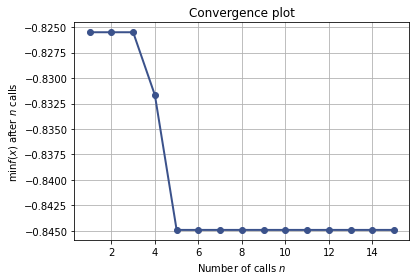

In [125]:
plot_convergence(result);

## 7.2 Light Gradient Boosting Machine Classifier

In [126]:
def tune_lgbm(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_samples = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
              
    #Model
    model = LGBMClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_samples=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5],
                                    random_state=0, n_jobs=-1)

    model.fit(x_train, y_train)

    # Prediction
    yhat = model.predict(x_val)

    # Prediction Proba
    yhat_proba = model.predict_proba(x_val)[:,1]
    # Performance
    # model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc = m.roc_auc_score(y_val, yhat_proba)
    
    return -roc

param = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_samples
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500)] #n_estimetors



result = forest_minimize(tune_lgbm, param, random_state=42, n_random_starts=15, n_calls=15, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.006259548184287541, 1, 1, 0.4008609501227462, 0.7984250789732436, 221]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.0739
Function value obtained: -0.8214
Current minimum: -0.8214
Iteration No: 2 started. Evaluating function at random point.
[0.0014321698289111518, 1, 1, 0.4397792655987209, 0.8005575058716045, 251]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.0338
Function value obtained: -0.8205
Current minimum: -0.8214
Iteration No: 3 started. Evaluating function at random point.
[0.004475983459259065, 1, 2, 0.37489944752007115, 0.9692763545078752, 485]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.9111
Function value obtained: -0.8210
Current minimum: -0.8214
Iteration No: 4 started. Evaluating function at random point.
[0.0015199348301309814, 1, 1, 0.186909009331792, 0.762378215816119, 335]
Iteration No: 4 ended. Evaluation done at random point.


In [127]:
result_list_lgbm = result.x
result_list_lgbm

[0.002816787814974816, 2, 2, 0.46699648960720747, 0.8636359979282104, 370]

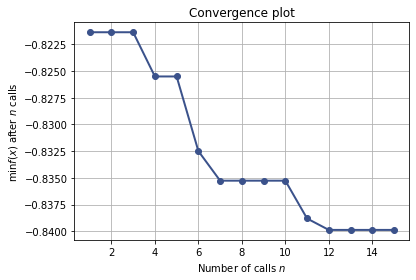

In [128]:
plot_convergence(result);

## 7.3 Random Forest Classifier

In [129]:
def tune_rfc(params):
    print(params)
    bootstrap         = params[0]
    max_depth         = params[1]
    max_features      = params[2]
    min_samples_leaf  = params[3]
    min_samples_split = params[4]
    n_estimators      = params[5]
              
    #Model
    model = RandomForestClassifier(bootstrap = params[0], max_depth=params[1], max_features=params[2],
                                    min_samples_leaf=params[3], min_samples_split=params[4], n_estimators=params[5],
                                    random_state=42, n_jobs=-1)

    model.fit(x_train, y_train)

    # Prediction
    yhat = model.predict(x_val)

    # Prediction Proba
    yhat_proba = model.predict_proba(x_val)[:,1]
    # Performance
    # model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc = m.roc_auc_score(y_val, yhat_proba)
    
    return -roc

param = [(True, False), #bootstrap
        (10, 100), #max_depth
        ('auto', 'sqrt'),#max_features
        (1, 4), #min_samples_leaf
        (2, 10), # min_samples_split
        (100, 500)] #n_estimetors

result = forest_minimize(tune_rfc, param, random_state=42, n_random_starts=15, n_calls=15, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[False, 24, 'sqrt', 1, 6, 202]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 80.7989
Function value obtained: -0.8419
Current minimum: -0.8419
Iteration No: 2 started. Evaluating function at random point.
[True, 96, 'auto', 4, 6, 199]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 60.4498
Function value obtained: -0.8416
Current minimum: -0.8419
Iteration No: 3 started. Evaluating function at random point.
[True, 12, 'auto', 2, 9, 393]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 97.1506
Function value obtained: -0.8509
Current minimum: -0.8509
Iteration No: 4 started. Evaluating function at random point.
[True, 69, 'auto', 4, 7, 352]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 114.9830
Function value obtained: -0.8419
Current minimum: -0.8509
Iteration No: 5 started. Evaluating function at random point.
[True, 58, 'sqrt', 3, 4, 463]
It

In [130]:
result_list_rfc = result.x
result_list_rfc

[True, 12, 'auto', 2, 9, 393]

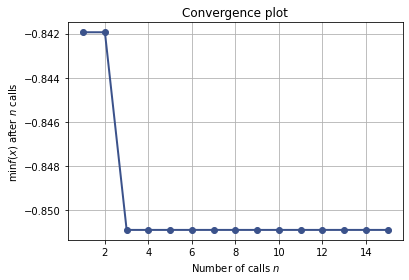

In [131]:
plot_convergence(result);

## 7.4 Cross Validation

In [132]:
xgb_model_tunned = xgb.XGBClassifier(learning_rate=0.008753903518006048, num_leaves=2 ** 2, max_depth=2, min_child_weight=2,
                                    subsample= 0.2234374261429623, colsample_bytree= 0.5079831261101071, n_estimators=485, gamma=4.421165132560786, reg_lambda=6,reg_alpha=83,
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

lgbm_model_tunned = LGBMClassifier(learning_rate=0.002816787814974816, num_leaves=2 ** 2, max_depth=2, min_child_samples=2,
                                    subsample=0.46699648960720747, colsample_bytree=0.8636359979282104, n_estimators=370,
                                    random_state=0, n_jobs=-1)

rfc_model_tunned = RandomForestClassifier(bootstrap = True, max_depth=11, max_features='sqrt',
                                    min_samples_leaf=3, min_samples_split=8, n_estimators=363,
                                    random_state=42, n_jobs=-1)

In [133]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost Classifier Tunned  CV', xgb_model_tunned, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier Tunned CV', xgb_model_tunned, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest Classifier Classifier Tunned CV', xgb_model_tunned, x_train, y_train)

In [134]:
models_performance_cv

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
0,Logistic Regression CV,0.303 +/- 0.0011,0.4952 +/- 0.0015,0.376 +/- 0.0011,0.8262 +/- 0.0012
1,K Neighbors Classifier CV,0.2918 +/- 0.002,0.4768 +/- 0.0029,0.3622 +/- 0.0025,0.7504 +/- 0.001
2,Random Forest Classifier CV,0.3112 +/- 0.0007,0.5086 +/- 0.0015,0.386 +/- 0.0011,0.828 +/- 0.0006
3,Naive Bayes Classifier CV,0.2804 +/- 0.0022,0.4586 +/- 0.0042,0.348 +/- 0.003,0.8148 +/- 0.0015
4,LightGBM Classifier CV,0.3404 +/- 0.0033,0.5568 +/- 0.0051,0.4226 +/- 0.004,0.8482 +/- 0.0012
5,XGBoost Classifier CV,0.3378 +/- 0.0037,0.552 +/- 0.006,0.419 +/- 0.0044,0.8462 +/- 0.0019
6,XGBoost Classifier Tunned CV,0.3316 +/- 0.0031,0.5422 +/- 0.0052,0.4118 +/- 0.0039,0.8414 +/- 0.0016
7,LightGBM Classifier Tunned CV,0.3404 +/- 0.0033,0.5568 +/- 0.0051,0.4226 +/- 0.004,0.8482 +/- 0.0012
8,Random Forest Classifier Classifier Tunned CV,0.3112 +/- 0.0007,0.5086 +/- 0.0015,0.386 +/- 0.0011,0.828 +/- 0.0006


## 7.5 Final model - LightGBM Classifier

<AxesSubplot:title={'center':'Lift Curve lgbm'}, xlabel='Percentage of sample', ylabel='Lift'>

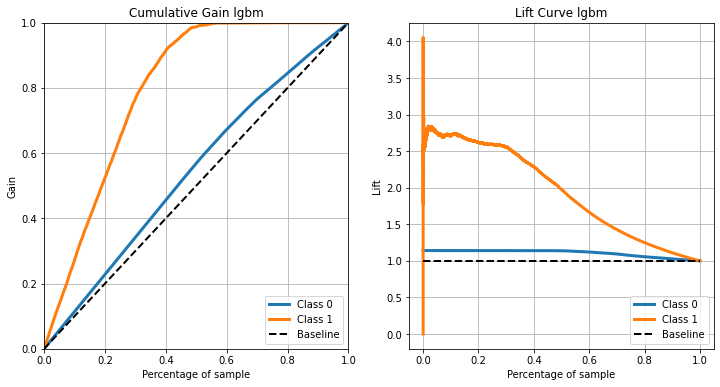

In [197]:
model_lgbm = lgbm_model_tunned.fit(x_train,y_train)

yhat_proba_lgbm_final = lgbm_model_tunned.predict_proba(x_val)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm_final, ax=axs[0],title='Cumulative Gain lgbm');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm_final,ax=axs[1],title='Lift Curve lgbm')

In [204]:
x_validation['response'] = y_validation
precision_lgbm = round(precision_at_k(x_validation, yhat_proba_lgbm_final, 0.20),3)
recall_lgbm= round(recall_at_k(x_validation, yhat_proba_lgbm_final, 0.20),3)
f1_lgbm = round(2*(precision_lgbm*recall_lgbm)/(precision_lgbm+recall_lgbm),3)
roc_lgbm = round(m.roc_auc_score(y_validation,yhat_proba_lgbm_final[:,1]),3)

print("Precision at k: {}" .format(precision_lgbm))
print("Recall at k: {}" .format(recall_lgbm))
print("F1-Score at k {}".format(f1_lgbm))
print("ROC AUC Score {}".format(roc_lgbm))

Precision at k: 0.244
Recall at k: 0.987
F1-Score at k 0.391
ROC AUC Score 0.84


# 8.0 Final results

## 8.1 Feature Engineering 

In [199]:
#Creating new features

#mapping vechicle_damage from NO to 0 and Yes to 1
vehicle_damage_mapping = {'No':0,
                          'Yes':1}
df_test['vehicle_damage'] = df_test['vehicle_damage'].map(vehicle_damage_mapping)

#annual_premium paid per day
df_test['annual_premium_per_day'] = df_test['annual_premium']/df_test['vintage']

#annual_premium divided per age
df_test['annual_premium_per_age'] = df_test['annual_premium']/df_test['age']

#vintage_per_age
df_test['vintage_per_age'] = df_test['vintage']/df_test['age']

#logic between previously_insured  and vehicle_damage
df_test['previously_insured_vehicle_damage'] =  df_test.apply(lambda row: -(row['vehicle_damage'] + row['previously_insured'])**2 if row['previously_insured'] == 0 else (row['vehicle_damage'] + row['previously_insured'])**2, axis=1)

#logic between vehicle_age (consider age > 1 as 1 and age < 1 as 0) and vehicle_damage
df_test['vehicle_age_vehicle_damage'] = df_test.apply(lambda row: -((row['vehicle_damage'] + 0)**2) if row['vehicle_age'] == '<1 Year' else (row['vehicle_damage'] + 1)**2, axis=1)

#logic between driving_license and vehicle_damage
df_test['vehicle_damage_license'] = df_test.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)

#logic between annual_premium divided per mean of annual_premium per region_code
df_test_annual_premium_mean_region_code = df_test.rename(columns={'annual_premium': 'annual_premium_mean'}).groupby('region_code').mean()
df_test_annual_premium_mean_region_code.reset_index(inplace=True)
df_test = df_test.merge(df_test_annual_premium_mean_region_code[['region_code', 'annual_premium_mean']], on='region_code', how='left')
df_test['annual_premium_per_ap_mean_rc'] = df_test.apply(lambda row: (row['annual_premium']/row['annual_premium_mean']) ,axis=1)
df_test.drop(columns='annual_premium_mean', inplace = True)
df_test_annual_premium_mean_region_code = None

#logic between annual_premium divided per mean of annual_premium per policy_sales_channel
df_test_annual_premium_mean_policy_sales_channel = df_test.rename(columns={'annual_premium': 'annual_premium_mean'}).groupby('policy_sales_channel').mean()
df_test_annual_premium_mean_policy_sales_channel.reset_index(inplace=True)
df_test = df_test.merge(df_test_annual_premium_mean_policy_sales_channel[['policy_sales_channel', 'annual_premium_mean']], on='policy_sales_channel', how='left')
df_test['annual_premium_per_ap_mean_psc'] = df_test.apply(lambda row: (row['annual_premium']/row['annual_premium_mean']) ,axis=1)
df_test.drop(columns='annual_premium_mean', inplace = True)
df_test_annual_premium_mean_policy_sales_channel = None

#logic of vehicle_damage_mean per region_code
df_test_vehicle_damage_mean_per_region_code = df_test.rename(columns={'vehicle_damage': 'vehicle_damage_mean_region_code'}).groupby('region_code').mean()
df_test_vehicle_damage_mean_per_region_code.reset_index(inplace=True)
df_test = df_test.merge(df_test_vehicle_damage_mean_per_region_code[['region_code', 'vehicle_damage_mean_region_code']], on='region_code', how='left')

## 8.2 Data Preparation

In [200]:
# annual_premium
df_test['annual_premium'] = ss_annual_premium.transform(df_test[['annual_premium']].values)

# annual_premium_per_day
df_test['annual_premium_per_day'] = ss_annual_premium_per_day.transform(df_test[['annual_premium_per_day']].values)

# annual_premium_per_age
df_test['annual_premium_per_age'] = ss_annual_premium_per_age.transform(df_test[['annual_premium_per_age']].values)

# annual_premium_per_ap_mean_rc
df_test['annual_premium_per_ap_mean_rc'] = ss_annual_premium_per_ap_mean_rc.transform(df_test[['annual_premium_per_ap_mean_rc']].values)

# annual_premium_per_ap_mean_psc
df_test['annual_premium_per_ap_mean_psc'] = ss_annual_premium_per_ap_mean_psc.transform(df_test[['annual_premium_per_ap_mean_psc']].values)

# vintage
df_test['vintage'] = mms_vintage.transform(df_test[['vintage']].values)

# age
df_test['age'] = mms_age.transform(df_test[['age']].values)

# vintage_per_age
df_test['vintage_per_age'] = mms_vintage_per_age.transform(df_test[['vintage_per_age']].values)

# vehicle_damage_mean_region_code
df_test['vehicle_damage_mean_region_code'] = mms_vehicle_damage_mean_region_code.transform(df_test[['vehicle_damage_mean_region_code']].values)

# gender
df_test.loc[:,'gender'] = df_test.loc[:,'gender'].map(target_encode_gender)

# region_code
df_test.loc[:,'region_code'] = df_test.loc[:,'region_code'].map(target_encode_region_code)

# policy_sales_channel
df_test.loc[:,'policy_sales_channel'] = df_test.loc[:,'policy_sales_channel'].map(fe_policy_sales_channel)

# vehicle_age
df_test = pd.get_dummies(df_test, prefix='vehicle_age', columns=['vehicle_age'])

# previously_insured_vehicle_damage
df_test.loc[:,'previously_insured_vehicle_damage'] = df_test.loc[:,'previously_insured_vehicle_damage'].map(target_encode_previously_insured_vehicle_damage)

# vehicle_age_vehicle_damage
df_test.loc[:,'vehicle_age_vehicle_damage'] = df_test.loc[:,'vehicle_age_vehicle_damage'].map(target_encode_vehicle_age_vehicle_damage)

# vehicle_damage_license
df_test.loc[:,'vehicle_damage_license'] = df_test.loc[:,'vehicle_damage_license'].map(target_encode_vehicle_damage_license)

df_test = df_test.dropna(axis=1)

In [201]:
df_test_copy = df_test.copy()
df_test = df_test[columns_selected]

yhat_proba_lgbm_final_test = lgbm_model_tunned.predict_proba(df_test)

df_test['score'] = yhat_proba_lgbm_final_test[:,1].tolist()
df_test['id'] = df_test_copy['id']
df_test=df_test.sort_values('score',ascending=False)
df_test=df_test.reset_index(drop=True)
df_test['ranking']=df_test.index+1

In [202]:
df_test[['id', 'ranking', 'score']]

,id,ranking,score
0,484775,1,0.219383
1,495486,2,0.219383
2,441205,3,0.219383
3,402912,4,0.219383
4,495483,5,0.219383
...,...,...,...
127032,425337,127033,0.043952
127033,482439,127034,0.043952
127034,425347,127035,0.043952
127035,425348,127036,0.043952


In [203]:
x_val

,age,vintage_per_age,annual_premium_per_day,vintage,annual_premium_per_age,annual_premium_per_ap_mean_rc,annual_premium_per_ap_mean_psc,annual_premium,previously_insured,vehicle_damage,vehicle_damage_mean_region_code
284256,0.015385,0.534409,-0.200704,0.550173,1.893035,0.757915,0.649851,0.718296,1,0,0.339784
217539,0.107692,0.143964,0.222830,0.176471,0.324594,-0.450275,-0.062193,-0.048092,1,1,1.000000
326940,0.369231,0.146405,0.088129,0.314879,0.071088,0.681010,0.526014,0.647634,0,1,0.339784
63073,0.369231,0.083551,0.465828,0.173010,-0.097378,-0.069481,0.291925,0.388983,0,1,1.000000
239864,0.523077,0.175192,-0.205007,0.474048,-0.365872,-0.082511,0.166236,0.374027,1,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
154977,0.430769,0.040753,1.002851,0.086505,-0.393871,0.073168,-0.077019,0.088769,0,1,0.349409
311699,0.369231,0.151004,-0.116874,0.325260,-0.325310,-0.374369,-0.119432,0.039033,0,1,1.000000
180349,0.384615,0.086003,-0.586443,0.183391,-1.407292,-1.760121,-1.279884,-1.618778,1,0,0.373214
299482,0.784615,0.025770,0.914369,0.089965,-0.773198,-0.373308,-0.118394,0.040251,1,0,1.000000


In [175]:
yhat_proba_lgbm_final_test[:,1].min()

0.04395230528761575